# Summary of Modeling for SPDR ETFs

In this notebook, I will summarize my findings from iterating through a host of models for the 11 sector ETFs for time frames of 1, 3, 6, and 12 months. The best scoring models performed well in terms of precision. There were still instances wherein the models predicted "buys" incorrectly, but the models generally did a good job of mitigating the magnitude of losses. The whole process was at times hindered by imbalanced data, or a lack of data for the two newer ETFs. I will begin this notebook by summarizing each sector's performance separately. 

### Disclaimer: This notebook should not be considered any kind of financial advice. It exists only for the purposes of practicing modeling and making predictions 

### Notebook Analysis Layout:
- Materials
- Energy
- Financials
- Industrials 
- Technology
- Staples 
- Utilities 
- Health Care
- Consumer Discretionary 
- Real Estate 
- Communication Services
- ##### Final Summary

![One Tree of an ExtraTreesClassifier Ensemble](./Files/extra_tree.jpg)

<hr style="border: 2px solid blue">

# Imports and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.dummy import DummyClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, recall_score, precision_score, f1_score, \
log_loss, auc, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingRegressor, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost
from xgboost import XGBClassifier

import datetime as dt

# New import of my custom class
from classification_classes import Model
from spider_classes import Materials, Energy, Financials, Industrials, Technology, Staples, Utilities, Health, \
Consumer, Real_Estate, Communication_Services
from other_functions import compare_curves

pd.set_option("display.max_rows", 25)
pd.set_option('display.max_columns', 35)
sns.set_style("dark")

import warnings

# Suppress FutureWarnings for all of scikit-learn's modules
warnings.filterwarnings("ignore")

import pickle

### Data

In [2]:
# Feature Importances for the best models of each sector/timeframe
feature_importances = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Feature_Importances.csv')
feature_importances.rename(columns={"Unnamed: 0": "Model Target"}, inplace=True)
feature_importances.set_index("Model Target", inplace=True)

# Complete table of results
models_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/ALL_MODEL_DATA.csv', index_col=0)
models_df.loc[28, 'name'] = "Gridsearched ETC Materials 12-Month"

# Original Data 
df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_DATA_W_ADDED.csv')
# df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/FULL_DATA_W_PERC_CHANGES.csv')
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

In [3]:
df.head()

Ticker  Adj Close      Close       High        Low       Open  \
Date                                                                       
1999-01-29    XLB  12.173973  21.109375  21.109375  20.953125  20.953125   
1999-01-29    XLE  11.670672  21.812500  21.812500  21.437500  21.687500   
1999-01-29    XLF  11.877566  19.369415  19.394800  18.810926  19.077478   
1999-01-29    XLI  15.624509  24.296875  24.406250  23.953125  24.234375   
1999-01-29    XLK  28.604773  37.812500  37.843750  36.937500  37.375000   

              Volume  GDP_Filled  Interest_Rates  Mkt-RF    SMB     HML  \
Date                                                                      
1999-01-29     400.0    9411.682            4.37  0.0095  0.001 -0.0062   
1999-01-29   18600.0    9411.682            4.37  0.0095  0.001 -0.0062   
1999-01-29   72998.0    9411.682            4.37  0.0095  0.001 -0.0062   
1999-01-29  109200.0    9411.682            4.37  0.0095  0.001 -0.0062   
1999-01-29  933600.0    9411.682            4.37  0.0095  0.001 -0.0062   

               RMW     CMA  garman_klass_vol        RSI  \
Date                                                      
1999-01-29  0.0044 -0.0057         -0.113866  45.359196   
1999-01-29  0.0044 -0.0057         -0.148177  31.112318   
1999-01-29  0.0044 -0.0057         -0.086272  53.698896   
1999-01-29  0.0044 -0.0057         -0.074248  54.474621   
1999-01-29  0.0044 -0.0057         -0.027333  69.725520   

            lowest_bollinger_band  ...  dollar_volume(M)  Quarter  Month  \
Date                               ...                                     
1999-01-29              11.895113  ...            0.0049        1      1   
1999-01-29              11.538886  ...            0.2171        1      1   
1999-01-29              11.237432  ...            0.8670        1      1   
1999-01-29              15.080736  ...            1.7062        1      1   
1999-01-29              24.579485  ...           26.7054        1      1   

            cycle_year  day_of_week  one_months_later  three_months_later  \
Date                                                                        
1999-01-29           3       Friday        1999-03-01          1999-04-29   
1999-01-29           3       Friday        1999-03-01          1999-04-29   
1999-01-29           3       Friday        1999-03-01          1999-04-29   
1999-01-29           3       Friday        1999-03-01          1999-04-29   
1999-01-29           3       Friday        1999-03-01          1999-04-29   

            six_months_later  twelve_months_later  One_Month_Change  \
Date                                                                  
1999-01-29        1999-07-29           2000-01-31          0.003700   
1999-01-29        1999-07-29           2000-01-31         -0.018624   
1999-01-29        1999-07-29           2000-01-31          0.019659   
1999-01-29        1999-07-29           2000-01-31          0.008360   
1999-01-29        1999-07-29           2000-01-31         -0.103306   

           Three_Month_Change Six_Month_Change Twelve_Month_Change  \
Date                                                                 
1999-01-29           0.304891         0.224777            0.120443   
1999-01-29           0.321353         0.294086            0.272486   
1999-01-29           0.138006         0.056829           -0.020673   
1999-01-29           0.199315         0.202136            0.131147   
1999-01-29          -0.018595         0.069421            0.337216   

           One_Month_Positive Three_Month_Positive  Six_Month_Positive  \
Date                                                                     
1999-01-29                1.0                  1.0                 1.0   
1999-01-29                0.0                  1.0                 1.0   
1999-01-29                1.0                  1.0                 1.0   
1999-01-29                1.0                  1.0                 1.0   
1999-01-29                0.0   

### Model Objects

In [4]:
# Load Pickled Classes -> if you want access, please reach out to me directly

with open('/Users/samalainabayeva/Desktop/Capstone Project/SPDR_classes.pkl', 'rb') as file:
    model_collection = pickle.load(file)

In [5]:
# Providing access to Class Objects

Materials = model_collection[0]
Energy = model_collection[1]
Financials = model_collection[2]
Industrials = model_collection[3]
Technology = model_collection[4]
Staples = model_collection[5]
Utilities = model_collection[6]
Health = model_collection[7]
Consumer_Disc = model_collection[8]
Real_Estate = model_collection[9]
Comms = model_collection[10]

In [6]:
# Metric dfs of the models from the previous notebook

Materials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Materials.csv', index_col=0)
Energy_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Energy.csv', index_col=0)
Financials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Financials.csv', index_col=0)
Industrials_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Industrials.csv', index_col=0)
Technology_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Technology.csv', index_col=0)
Staples_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Staples.csv', index_col=0)
Utilities_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Utilities.csv', index_col=0)
Health_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Health_Care.csv', index_col=0)
Consumer_Disc_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Consumer_Disc.csv', index_col=0)
Real_Estate_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Real_Estate.csv', index_col=0)
Comms_df = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Communication_Services.csv', index_col=0)

### Functions

In [7]:
def plot_test_precision(df, sector_name:str, num_include=-1):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(10,7))
    palette = sns.color_palette("flare", n_colors=10)
    data = df[['name', 'test_prec']].sort_values(by="test_prec", ascending=False)[0:num_include]
    sns.barplot(data=data, y='name', x="test_prec", palette=palette)
    ax.set_xlabel("Test Precision")
    ax.set_ylabel("Model Name")
    ax.set_title(f"Performance of Models - {sector_name}")
    ax.set_xticks(np.arange(0,1,.1))
    ax.set_xticklabels(np.arange(0,100,10))
    plt.grid(False);
    
    
    
feature_importances = pd.read_csv('/Users/samalainabayeva/Desktop/Capstone Project/Feature_Importances.csv')
feature_importances.rename(columns={"Unnamed: 0": "Model Target"}, inplace=True)
feature_importances.set_index("Model Target", inplace=True)
    
    
    
def print_feature_importances(start, stop, interval=1, feats=5, data=feature_importances):
    for i in range(start, stop, interval):
        #find top absolute values
        top_values = feature_importances.iloc[i].abs().sort_values(ascending=False)[:feats]
        # Access the column names
        column_names = top_values.index.tolist()
        # sort values by absolute value without changing sign
        sorted_values = sorted(round(feature_importances.iloc[i], 4), key=lambda x: abs(x), reverse=True)[:feats]
        zip_feats = list(zip(column_names, sorted_values))
        
        
        print("*" *40)
        print(f"Top {feats} Feature Importance(s):")
        for z in zip_feats:
            print(z)
        
        

def describe_predictions(model, ticker, df=df, cat=1, box=False):
    targets = df[df["Ticker"] == ticker][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change', \
                                         'Twelve_Month_Change']]

    combined_df = model.X_test.join(targets)
    predictions = list(model.y_pred)
    combined_df["Y_PREDS"] = predictions
    
    # Add this stuff
    if box:
        assess_positive_preds = combined_df[combined_df["Y_PREDS"] == 1]

        fig, ax = plt.subplots(figsize=(6,5.5))
        sns.set_style("darkgrid")
        palette = sns.color_palette("rocket_r", n_colors=6)
        sns.boxplot(assess_positive_preds[["One_Month_Change", 'Three_Month_Change','Six_Month_Change',\
                                           'Twelve_Month_Change']], ax=ax, palette=palette)
        ax.set_title(f"{model.name} Box Plot for Each Timeframe")
        plt.xticks(rotation=30)
        ax.set_ylabel("Percentage Change in Decimals");
    else:
        print("Set 'box' to 'True' if you want to see box plots")

    return combined_df[combined_df["Y_PREDS"] == cat][['One_Month_Change', 'Three_Month_Change', 'Six_Month_Change',\
                                                     'Twelve_Month_Change']].describe()


def show_time_horizon(df, time_horizon):
    time_dict = {"One":"1-Month", "Three":"3-Month", "Six":'6-Month', "Twelve":'12-Month'}
    return df[df['name'].str.contains(str(time_dict[time_horizon]))].sort_values(by="test_prec", ascending=False)

<hr style="border: 4px solid blue">

# Top Ten Models Overall
There were several models with 100% precision, but they predicted "buy" so infrequently that the models had no practical use case. All lists will be the top "useful" models, but a number of these models still predict "buy" at a very low rate.

In [109]:
models_df.sort_values(by="test_prec", ascending=False)[15:25]

name  train_accuracy  train_prec  \
68             Financials XGBoost 6-Month        0.447535    0.712225   
148    Grid Searched LR, 12-Month Staples        0.613906    0.947064   
144  Staples Logistic Regression 12-Month        0.588875    0.946635   
61         Financials Extra Trees 3-Month        0.459671    0.615987   
165             Utilities XGBoost 6-Month        0.519343    0.730022   
85      Industrials Random Forest 3-Month        0.488748    0.793511   
187          Health Random Forest 6-Month        0.462705    0.825016   
193         Health Random Forest 12-Month        0.640961    0.907582   
91      Industrials Random Forest 6-Month        0.425790    0.850129   
92        Industrials Extra Trees 6-Month        0.580278    0.908441   

     train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
68       0.390537  0.455941       0.478114   0.991379     0.156676  0.270588   
148      0.621605  0.684687       0.688552   0.985155     0.670340  0.797814   
144      0.600563  0.665279       0.702020   0.984190     0.685950  0.808442   
61       0.398116  0.445721       0.468855   0.970930     0.210593  0.346114   
165      0.592715  0.582059       0.298822   0.970874     0.107527  0.193611   
85       0.437685  0.464331       0.500000   0.966480     0.227332  0.368085   
187      0.401086  0.422490       0.370370   0.966346     0.213376  0.349565   
193      0.572817  0.633259       0.430135   0.958115     0.356378  0.519517   
91       0.323543  0.431109       0.497475   0.956284     0.229058  0.369588   
92       0.531628  0.580356       0.494108   0.950276     0.225131  0.364021   

     test_logloss       AUC  
68       3.035870  0.630505  
148      1.192832  0.835453  
144      0.953197  0.830769  
61       0.828621  0.733858  
165      3.695586  0.654876  
85       0.914622  0.741533  
187      0.749420  0.620952  
193      0.692242  0.636803  
91       1.026597  0.654387  
92       0.786628  0.614192

<hr style="border: 4px solid black">

# Best Models for Different Time Horizons
### Top 5 Models for 1-Month Predictions

In [110]:
show_time_horizon(models_df, "One").sort_values(by='test_prec', ascending=False)[1:6]

name  train_accuracy  train_prec  \
199                Consumer Random Forest 1-Month        0.453350    0.661459   
175                  Health Random Forest 1-Month        0.520354    0.705112   
153                     Utilities XGBoost 1-Month        0.515550    0.654395   
82   GridSearched Best-Model, 1-Month Industrials        0.492035    0.713167   
79              Industrials Random Forest 1-Month        0.495828    0.711495   

     train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
199      0.323308  0.396286       0.388889   0.909091     0.013605  0.026810   
175      0.443755  0.494029       0.399832   0.851852     0.031421  0.060606   
153      0.581357  0.586978       0.408249   0.833333     0.073628  0.135301   
82       0.411842  0.440730       0.523569   0.763780     0.277143  0.406709   
79       0.420619  0.448566       0.488215   0.750000     0.197143  0.312217   

     test_logloss       AUC  
199      1.034222  0.560923  
175      1.022858  0.561392  
153      2.974106  0.592095  
82       0.835841  0.654516  
79       0.875377  0.647339

One_Month_Change
count         11.000000
mean           0.077376
std            0.048108
min           -0.050385
25%            0.071055
50%            0.086260
75%            0.094430
max            0.150902

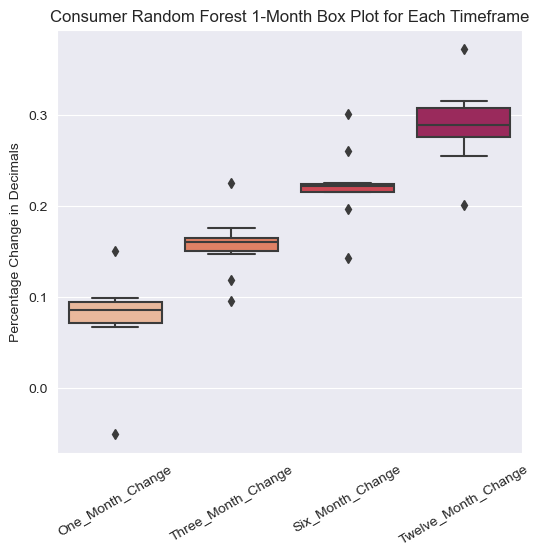

In [46]:
# 5th model| -14% worst, +25.3% best, 3.9% mean, 3.3% median | 46.8 % annualized
# describe_predictions(Industrials[2], "XLI", box=True)[["One_Month_Change"]] 

# 4th model| - 14% worst, +25.3% best, 4% mean, 3.8% median | 48% annualized return
# describe_predictions(Industrials[5], "XLI", box=True)[["One_Month_Change"]]

# 3rd model| -19.5% worst, +29% best, 3.3% mean, 3.1% median | 39.6% annualized
# describe_predictions(Utilities[4], "XLU", box=True)[["One_Month_Change"]] 

# 2nd model| -1.7% worst, + 5.9% best, 2.1% mean, 1.9% median |25.2% annualized
# describe_predictions(Health[2], "XLV", box=True)[["One_Month_Change"]]

# 1st model| -5% worst, +15.1% best, 7.7% mean, 8.6% median 92.4% annualized
describe_predictions(Consumer_Disc[2], "XLY", box=True)[["One_Month_Change"]]

### Top 5 Models for 3-Month Predictions

In [111]:
show_time_horizon(models_df, "Three").sort_values(by='test_prec', ascending=False)[2:7]

name  train_accuracy  train_prec  \
61               Financials Extra Trees 3-Month        0.459671    0.615987   
85            Industrials Random Forest 3-Month        0.488748    0.793511   
157             Utilities Random Forest 3-Month        0.519090    0.671392   
11              Materials Random Forest 3-Month        0.479646    0.746665   
14   GridSearched Best-Model, 3-Month Materials        0.484197    0.753052   

     train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
61       0.398116  0.445721       0.468855   0.970930     0.210593  0.346114   
85       0.437685  0.464331       0.500000   0.966480     0.227332  0.368085   
157      0.609332  0.555249       0.325758   0.911504     0.115213  0.204568   
11       0.390127  0.449726       0.552189   0.877778     0.322011  0.471173   
14       0.399985  0.460092       0.552189   0.866906     0.327446  0.475345   

     test_logloss       AUC  
61       0.828621  0.733858  
85       0.914622  0.741533  
157      1.492251  0.533627  
11       0.861515  0.675493  
14       0.838969  0.665239

Three_Month_Change
count          172.000000
mean             0.112667
std              0.080046
min             -0.042844
25%              0.043411
50%              0.093480
75%              0.175027
max              0.276382

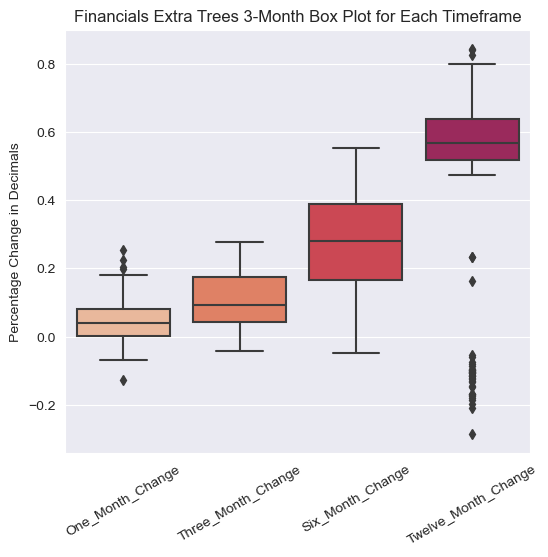

In [84]:
# 5th model -13.6% worst, +47.3% best, 8.7% mean, 5.4% median, 34.8% annualized
# describe_predictions(Materials[14], "XLB", box=True)[["Three_Month_Change"]]

# 4th model | - 13.6% worst, +47.3% best, 8.9% mean, 5.7% median, 35.6% annualized 
# describe_predictions(Materials[11], "XLB", box=True)[["Three_Month_Change"]]

# 3rd model |  -1.1% worst, +14.2% best, 4.8% mean, 4.1% median, 19.2% annualized
# describe_predictions(Utilities[8], "XLU", box=True)[["Three_Month_Change"]]

# 2nd model | -6.2% worst, +42.2% best, 13% mean, 13% median, 52% annualized
# describe_predictions(Industrials[8], "XLI", box=True)[["Three_Month_Change"]] 

# 1st model |  -4.2% worst, +27.6% best, 11.3% mean, 9.3% median, 45.2% annualized
describe_predictions(Financials[10], "XLF", box=True)[["Three_Month_Change"]]

### Top 5 Models for 6-Month Predictions

In [112]:
show_time_horizon(models_df, "Six").sort_values(by='test_prec', ascending=False)[6:11]

name  train_accuracy  train_prec  \
187       Health Random Forest 6-Month        0.462705    0.825016   
91   Industrials Random Forest 6-Month        0.425790    0.850129   
92     Industrials Extra Trees 6-Month        0.580278    0.908441   
67      Financials Extra Trees 6-Month        0.468268    0.682769   
141            Staples XGBoost 6-Month        0.474842    0.838947   

     train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
187      0.401086  0.422490       0.370370   0.966346     0.213376  0.349565   
91       0.323543  0.431109       0.497475   0.956284     0.229058  0.369588   
92       0.531628  0.580356       0.494108   0.950276     0.225131  0.364021   
67       0.474922  0.517100       0.514310   0.938547     0.228883  0.368018   
141      0.455912  0.518531       0.255892   0.929825     0.056806  0.107071   

     test_logloss       AUC  
187      0.749420  0.620952  
91       1.026597  0.654387  
92       0.786628  0.614192  
67       0.857412  0.713623  
141      4.129593  0.572259

Six_Month_Change
count        208.000000
mean           0.094231
std            0.070821
min           -0.041772
25%            0.039094
50%            0.088597
75%            0.123188
max            0.376824

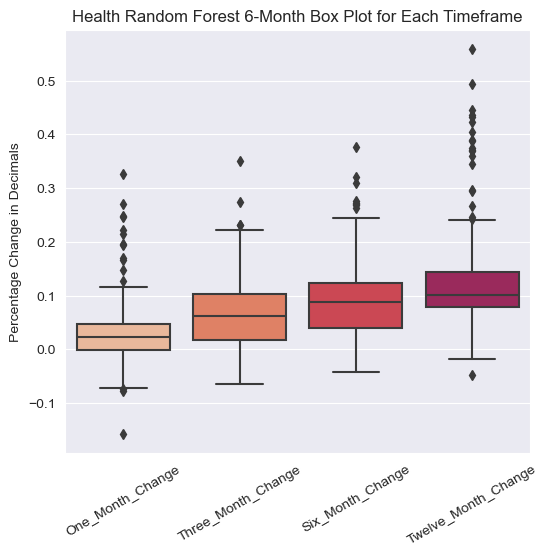

In [113]:
# 5th model -0.7% worst, +30.0% best, 12.1% mean, 12.1 median, 24.2% annualized
# describe_predictions(Staples[16], "XLP", box=True)[["Six_Month_Change"]]

# 4th model | -9.5% worst, +55.3% best, 26% mean, 27.3% median, 52% annualized
# describe_predictions(Financials[16], "XLF", box=True)[["Six_Month_Change"]]

# 3rd model |  -23.7% worst, +55.6% best, 22.5% mean, 25.1% median, 45% annualized 
# describe_predictions(Industrials[15], "XLI", box=True)[["Six_Month_Change"]]

# 2nd model | -7% worst, +55.6% best, 21.6% mean, 22.7% median, 43.2% annualized
# describe_predictions(Industrials[14], "XLI", box=True)[["Six_Month_Change"]]

# 1st model |  -4.2% worst, +37.7% best, 9.4% mean, 8.9% median, 18.8% annualized
describe_predictions(Health[14], "XLV", box=True)[["Six_Month_Change"]]

### Top 5 Models for 12-Month Predictions, DUMMY MODEL INCLUDED!

In [115]:
show_time_horizon(models_df, "Twelve").sort_values(by='test_prec', ascending=False)[10:15]

name  train_accuracy  \
193                      Health Random Forest 12-Month        0.640961   
23                    Materials Random Forest 12-Month        0.447282   
143                             Dummy Staples 12-Month        0.724399   
265  Communication_Services Logistic Regression 12-...        0.807042   
73                   Financials Random Forest 12-Month        0.318331   

     train_prec  train_recall  train_f1  test_accuracy  test_prec  \
193    0.907582      0.572817  0.633259       0.430135   0.958115   
23     0.916382      0.401137  0.420653       0.478956   0.945122   
143    0.696334      0.800000  0.741708       0.916667   0.916667   
265    0.639842      0.796296  0.693229       0.789720   0.909091   
73     0.663155      0.349520  0.303211       0.667508   0.900000   

     test_recall   test_f1  test_logloss       AUC  
193     0.356378  0.519517      0.692242  0.636803  
23      0.202614  0.333692      1.069748  0.618211  
143     1.000000  0.956522      3.003638  0.500000  
265     0.714286  0.800000      0.480459  0.898719  
73      0.367973  0.522370      0.820425  0.663471

Twelve_Month_Change
count           382.000000
mean              0.152403
std               0.099604
min              -0.064900
25%               0.083817
50%               0.136607
75%               0.212293
max               0.558839

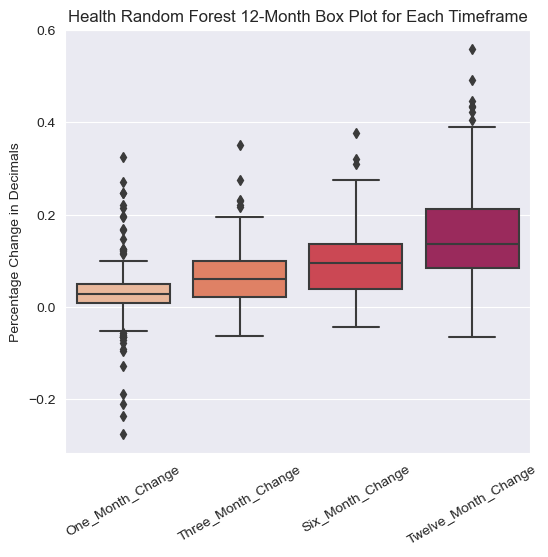

In [134]:
# 5th model -30.1% worst, +91.9% best, 46.4% mean, 56.2% median, 46.4% annualized
# describe_predictions(Financials[22], "XLF", box=True)[["Twelve_Month_Change"]]

# 4th model | - 25% worst, +45.3% best, 17.8% mean, 19.5% median, 17.8% annualized
# describe_predictions(Comms[20], "XLC", box=True)[["Twelve_Month_Change"]]

# 3rd model |  -9.4% worst, +41.6% best, 10.3% mean, 9.8% median, 10.3% annualized, rather low
# describe_predictions(Staples[18], "XLP", box=True)[["Twelve_Month_Change"]]

# 2nd model | -24% worst, +102.3% best, 35.6% mean, 18.4% median 35.6% annualized, very erratic
# describe_predictions(Materials[23], "XLB", box=True)[["Twelve_Month_Change"]]

# 1st model |  -6.5% worst, +55.9% best, 15.2% mean, 13.7% median, 15.2% annualized
describe_predictions(Health[20], "XLV", box=True)[["Twelve_Month_Change"]]

In [29]:
# Approximate annual returns by sector

for sector in df["Ticker"].unique():
    print(f"{sector} Mean Return Over 12-Months: {round(df[df['Ticker']== sector]['Twelve_Month_Change'].mean()*100, 2)}%")

XLB Mean Return Over 12-Months: 9.31%
XLE Mean Return Over 12-Months: 11.13%
XLF Mean Return Over 12-Months: 7.36%
XLI Mean Return Over 12-Months: 9.39%
XLK Mean Return Over 12-Months: 10.26%
XLP Mean Return Over 12-Months: 7.73%
XLU Mean Return Over 12-Months: 8.5%
XLV Mean Return Over 12-Months: 9.03%
XLY Mean Return Over 12-Months: 10.39%
XLRE Mean Return Over 12-Months: 7.08%
XLC Mean Return Over 12-Months: 9.9%


<hr style="border: 4px solid black">

# Sector Analysis

# Materials XLB

No matter the time horizon, the macro-economic factors like interest rates and GDP were the most important features in all models. 

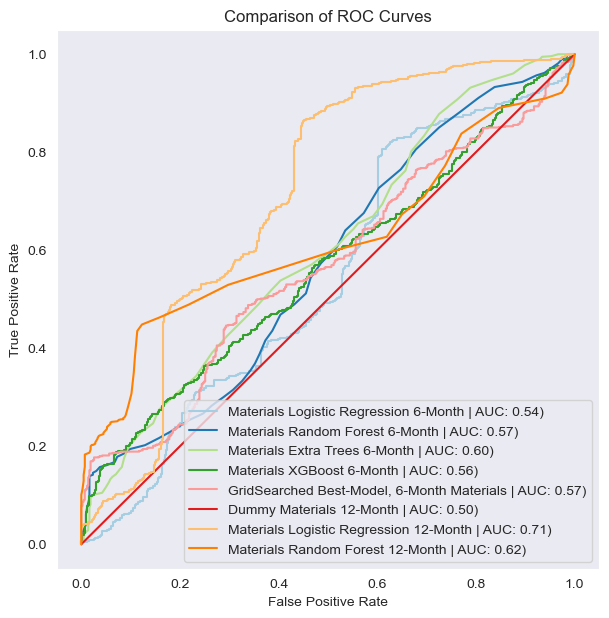

In [249]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Materials[16], Materials[17],Materials[18],Materials[19],Materials[20],Materials[21], Materials[22], \
                Materials[23]])

### Best Models for the Sector

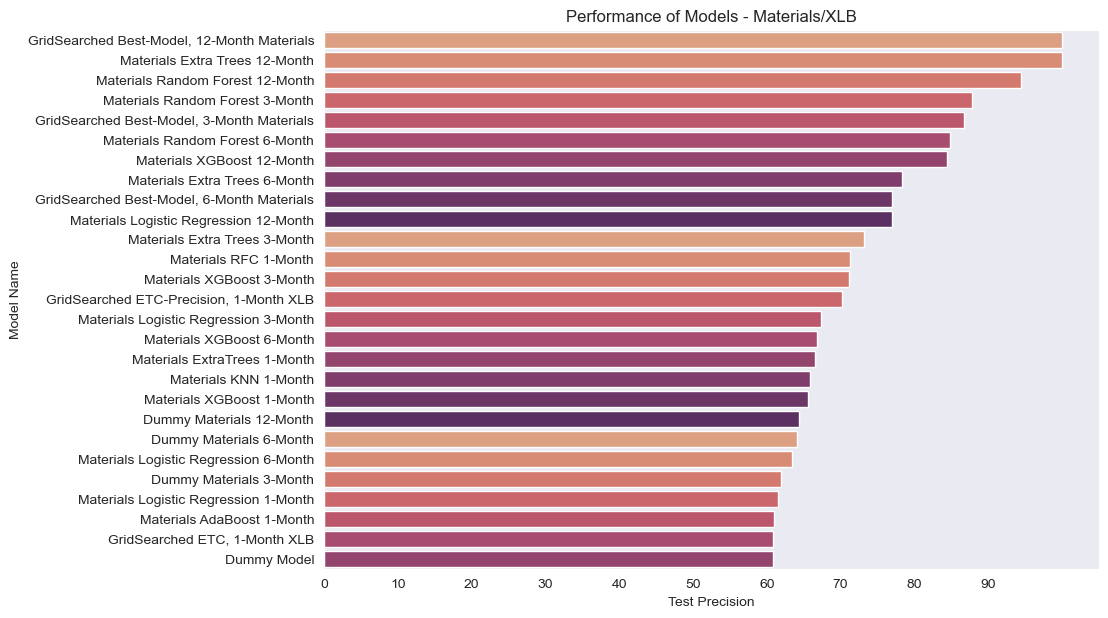

In [140]:
# Plotting the Test Precision of every model for this ETF

plot_test_precision(Materials_df, "Materials/XLB", num_include=30)

In [142]:
# Top 5 Materials Models - omitting the 100% precise models
Materials_df.sort_values(by="test_prec", ascending=False)[2:7]

name  train_accuracy  train_prec  \
23            Materials Random Forest 12-Month        0.447282    0.916382   
11             Materials Random Forest 3-Month        0.479646    0.746665   
14  GridSearched Best-Model, 3-Month Materials        0.484197    0.753052   
17             Materials Random Forest 6-Month        0.510493    0.848479   
25                  Materials XGBoost 12-Month        0.395449    0.934517   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
23      0.401137  0.420653       1.024766       0.478956   0.945122   
11      0.390127  0.449726       0.969973       0.552189   0.877778   
14      0.399985  0.460092       0.954680       0.552189   0.866906   
17      0.445771  0.521992       0.970971       0.443603   0.848276   
25      0.316916  0.347778       3.184510       0.486532   0.844444   

    test_recall   test_f1  test_logloss       AUC  
23     0.202614  0.333692      1.069748  0.618211  
11     0.322011  0.471173      0.861515  0.675493  
14     0.327446  0.475345      0.838969  0.665239  
17     0.161417  0.271224      0.892874  0.572585  
25     0.248366  0.383838      2.837078  0.532899

### How did our model perform when predicting "BUY"?
Our best model was a 12-month model, based on the RandomForestClassifier. As you can see below, the `median return on predicted "buys" was 18.5%.` The worst outcome of 12-Month positive predictions was a `loss of 24%`. The mean returns for this model were severely skewed to the right, and therefore median likely provides a better estimate of expected returns.

Twelve_Month_Change
count           164.000000
mean              0.356170
std               0.309449
min              -0.239530
25%               0.126010
50%               0.184869
75%               0.668235
max               1.023177

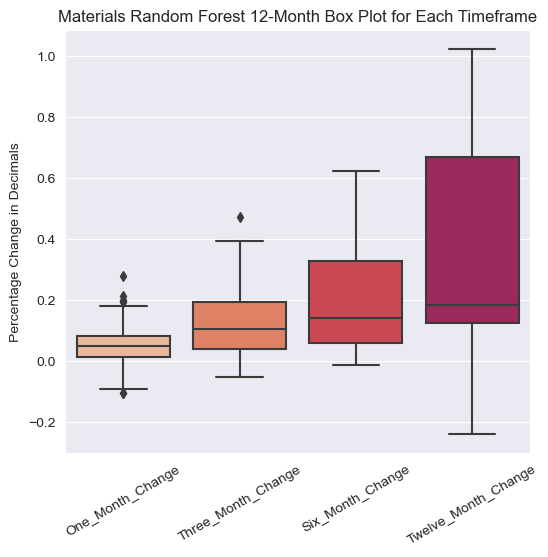

In [248]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Materials[23], "XLB", cat=1, box=True)[["Twelve_Month_Change"]]

Twelve_Month_Change
count          1188.000000
mean              0.114985
std               0.208887
min              -0.299151
25%              -0.038685
50%               0.075111
75%               0.194985
max               1.023177

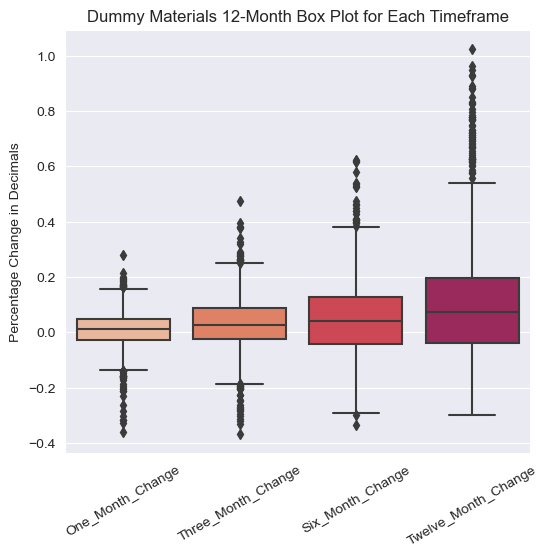

In [247]:
# Comparison to the dummy for the same target timeframe
describe_predictions(Materials[21], "XLB", cat=1, box=True)[["Twelve_Month_Change"]]

### Improvements
The confusion matrices below show how our best model slightly improved over the dummy model in terms of precision. The mean performance of the dummy model's returns was actually slightly higher than our candidate model, so to say that we made improvements may not be fully accurate depending on the use case. 

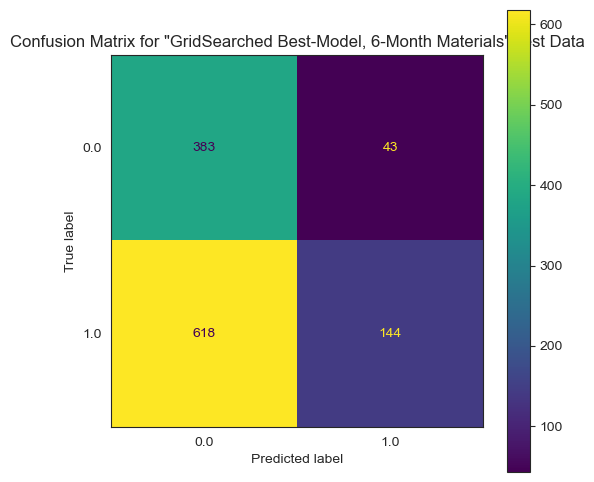

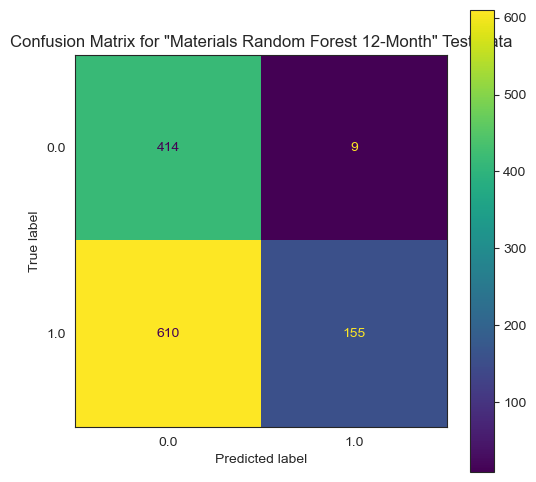

In [145]:
# Shows the best model's predictions and the dummy for that particular time horizon

Materials[20].confusion_matrix(), Materials[23].confusion_matrix();

### Feature Importances
Feature Importances for each time-horizon's best model. Keep in mind that after preprocessing and One Hot Encoding, that these models were built with `48 total feature columns.`  If all features were of equivalent value, they would each have an importance of roughly `0.021`. Also, `this list contains both importances and coefficients.` The importances are all positive numbers, summing to a total of 1, whereas coefficients are just that, and have no bounds on their values. GDP and Interest Rates dominate the top features for each of the time targets within this sector. 

In [192]:
# Feature Importances for each time-horizon's best model
print_feature_importances(0, 4, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0458)
('Interest_Rates', 0.0458)
('upper_bollinger_band', 0.044)
('one_up_bollinger_band', 0.0438)
('lowest_bollinger_band', 0.0436)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0863)
('Interest_Rates', 0.0681)
('lowest_bollinger_band', 0.0646)
('lower_bollinger_band', 0.0575)
('ATR', 0.0525)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0843)
('Interest_Rates', 0.0662)
('upper_bollinger_band', 0.0565)
('one_up_bollinger_band', 0.056)
('ATR', 0.0541)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.1429)
('garman_klass_vol', 0.0872)
('Interest_Rates', 0.0838)
('one_up_bollinger_band', 0.0555)
('Adj Close', 0.0554)


<hr style="border: 4px solid black">

# Energy XLE

This sector proved difficult to model. None of our model's precision scores were impressive, but the return profiles are solid. 

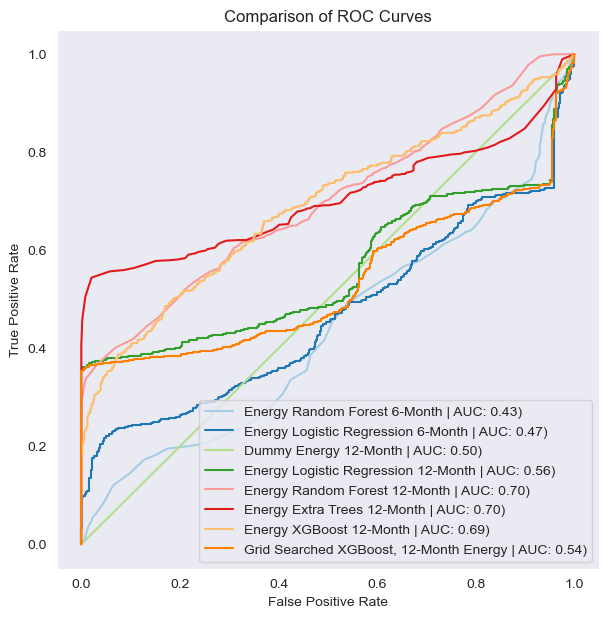

In [148]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Energy[14], Energy[13], Energy[18],Energy[19],Energy[20],Energy[21], Energy[22], Energy[23]])

### Best Models for the Sector

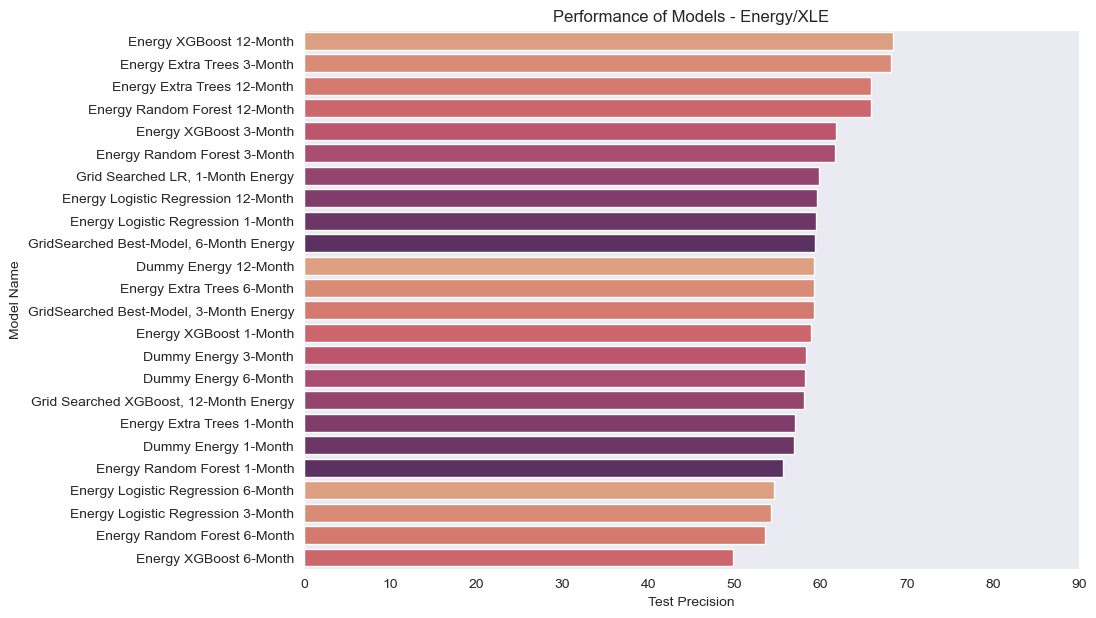

In [149]:
# Plotting the Test Precision of every model for this ETF

plot_test_precision(Energy_df, "Energy/XLE", num_include=30)

In [204]:
# These were the models with the highest precision score for this ETF

Energy_df.sort_values(by='test_prec', ascending=False)[:5]

name  train_accuracy  train_prec  train_recall  \
22        Energy XGBoost 12-Month        0.524147    0.668951      0.550380   
9      Energy Extra Trees 3-Month        0.553477    0.670291      0.650945   
21    Energy Extra Trees 12-Month        0.636410    0.883401      0.660809   
20  Energy Random Forest 12-Month        0.576738    0.670362      0.618834   
10         Energy XGBoost 3-Month        0.548925    0.657230      0.632983   

    train_f1  train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
22  0.544030       2.946381       0.641414   0.684350     0.732955  0.707819   
9   0.614124       0.946960       0.602694   0.681445     0.598846  0.637481   
21  0.650892       1.899941       0.606061   0.658602     0.696023  0.676796   
20  0.582867       1.986396       0.617003   0.658599     0.734375  0.694426   
10  0.620070       2.201706       0.557239   0.618105     0.630592  0.624286   

    test_logloss       AUC  
22      2.346408  0.690285  
9       0.800735  0.595156  
21      1.097799  0.704270  
20      0.794680  0.696280  
10      2.607554  0.562941

### How did our model perform when predicting "BUY"?
The best model for the sector was a 12-month XGBoost model. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 44%. The worst outcome on a predicted "buy" was a loss of 48.8%.` The max gain was `120.3%!`. These results are quite extreme obviously. Our model improved on mean gain by 11% over the dummy model.

Twelve_Month_Change
count           754.000000
mean              0.279307
std               0.428191
min              -0.487484
25%              -0.123389
50%               0.438894
75%               0.605599
max               1.202586

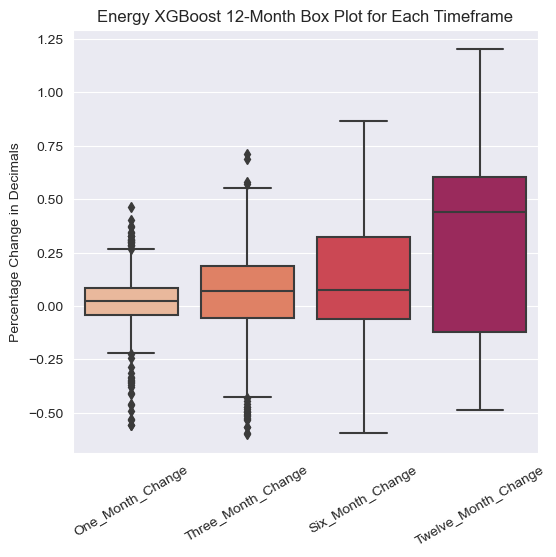

In [244]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Energy[22], "XLE", cat=1, box=True)[["Twelve_Month_Change"]]

Twelve_Month_Change
count          1188.000000
mean              0.169901
std               0.400466
min              -0.620742
25%              -0.161083
50%               0.139244
75%               0.517642
max               1.202586

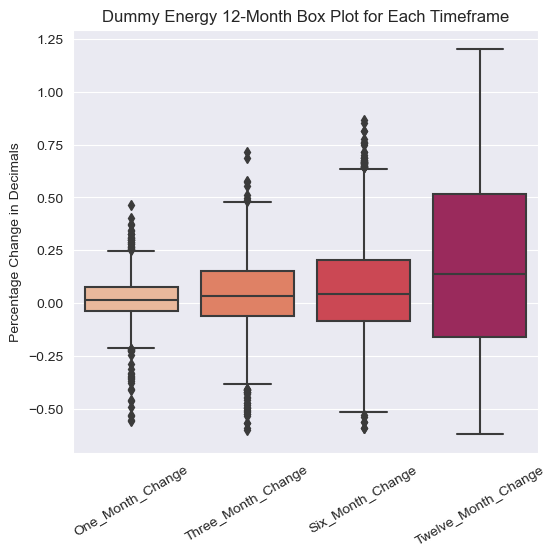

In [243]:
# Dummy Comparison
describe_predictions(Energy[18], "XLE", cat=1, box=True)[["Twelve_Month_Change"]]

### Comparison of Dummy Confusion Matrix to the Best Model

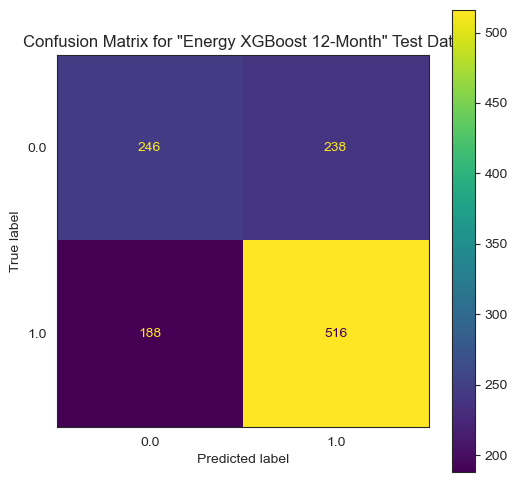

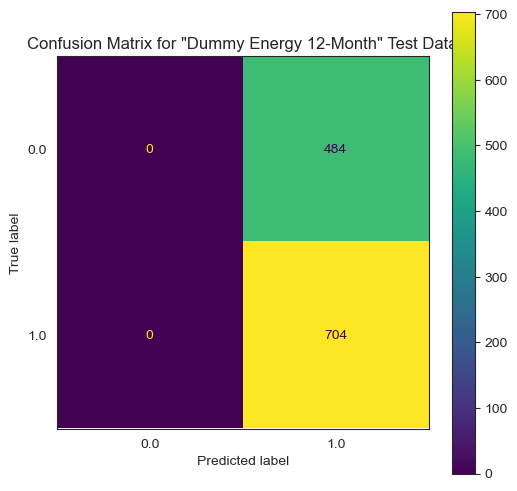

In [159]:
# Shows the best model's predictions and the dummy for that particular time horizon
Energy[22].confusion_matrix(), Energy[18].confusion_matrix();

### Feature Importances
The top model for the 1-month time frame was a Logistic Regression model. You will always notice this if you detect negative numbers, or values that sum to more than 1. This LR model being the most precise is illustrative of how noisy the results were when modeling over a 1-month timeframe in this sector. Keep this in mind as you peruse the feature imporances.

In [195]:
# Feature Importances for each time-horizon's best model
print_feature_importances(4, 8, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
('Adj Close', -3.6027)
('Low', 1.0841)
('dollar_volume(M)', -1.0179)
('Volume', 0.9215)
('High', 0.8318)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0548)
('one_up_bollinger_band', 0.0461)
('upper_bollinger_band', 0.0435)
('Interest_Rates', 0.0431)
('Adj Close', 0.0431)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0818)
('cycle_year_1', 0.079)
('High', 0.0589)
('cycle_year_3', 0.0574)
('Low', 0.0559)
****************************************
Top 5 Feature Importance(s):
('High', 0.2192)
('GDP_Filled', 0.1449)
('cycle_year_1', 0.1318)
('Month_12', 0.1135)
('Month_7', 0.0646)


<hr style="border: 4px solid black">

# Financials XLF

1-month results were again noisy. As timeframes were extended, GDP, interest rates, and ATR, a measure of volatility, became the most influential factors. 

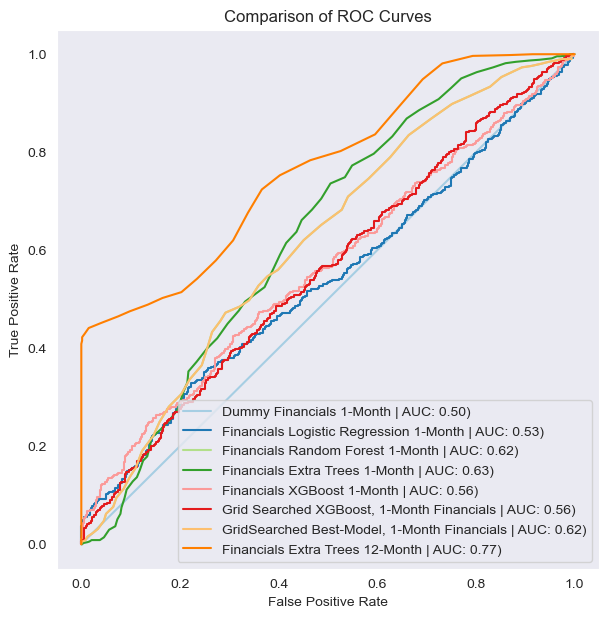

In [196]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Financials[0], Financials[1], Financials[2],Financials[3],Financials[4],Financials[5], \
                Financials[6], Financials[23]])

### Best Models for the Sector

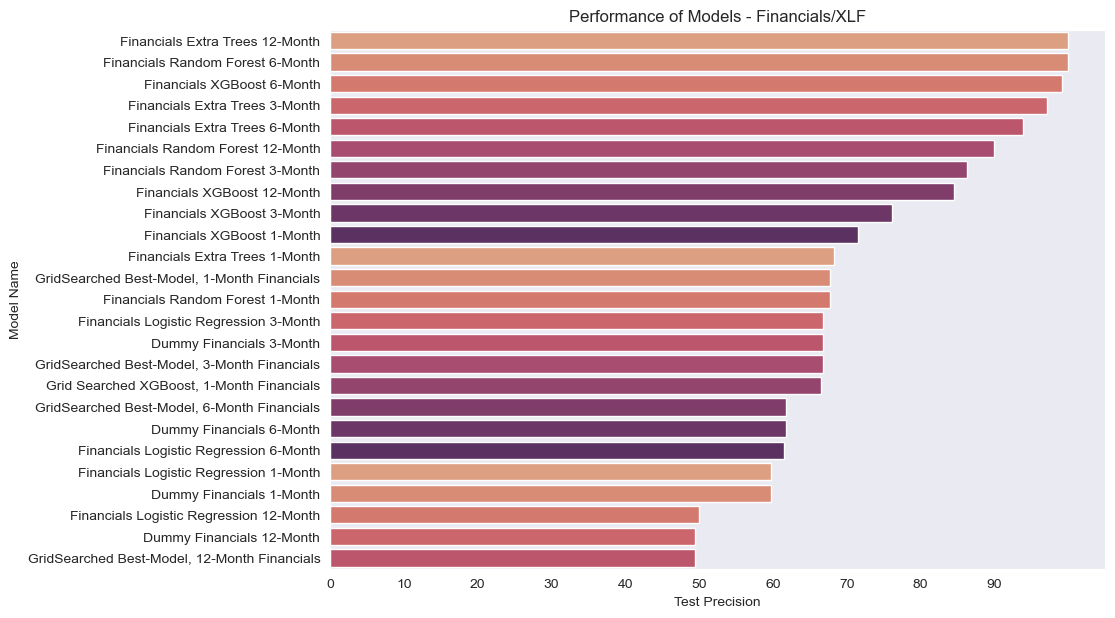

In [197]:
# Plotting the Test Precision of every model for this ETF

plot_test_precision(Financials_df, "Financials/XLF", num_include=30)

In [203]:
# These were the models with the highest precision score for this ETF with < 100% precision

Financials_df.sort_values(by='test_prec', ascending=False)[4:9]

name  train_accuracy  train_prec  \
16     Financials Extra Trees 6-Month        0.468268    0.682769   
22  Financials Random Forest 12-Month        0.318331    0.663155   
9    Financials Random Forest 3-Month        0.452086    0.595561   
24        Financials XGBoost 12-Month        0.329709    0.554144   
11         Financials XGBoost 3-Month        0.415676    0.633232   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
16      0.474922  0.517100       0.870650       0.514310   0.938547   
22      0.349520  0.303211       2.529491       0.667508   0.900000   
9       0.317126  0.361997       0.949610       0.483165   0.862348   
24      0.383455  0.324464       4.519128       0.694444   0.845679   
11      0.334558  0.400256       2.563376       0.526936   0.760722   

    test_recall   test_f1  test_logloss       AUC  
16     0.228883  0.368018      0.857412  0.713623  
22     0.367973  0.522370      0.820425  0.663471  
9      0.268600  0.409615      0.959344  0.659845  
24     0.466780  0.601537      1.547164  0.668236  
11     0.424968  0.545307      1.504583  0.610136

### How did our model perform when predicting "BUY"?
The best reasonable model was a 6-month ExtraTreesClassifier model. As you can see below, looking only at the "Six_Month_Change" column, the `median return on predicted "buys" for 12-Months was 27.3%. The worst outcome on a predicted "buy" was a loss of 9.5%.` The dummy model for this timeframe fared MUCH worse as you can see below.

Six_Month_Change
count        179.000000
mean           0.260153
std            0.150984
min           -0.094891
25%            0.177422
50%            0.273384
75%            0.382545
max            0.552720

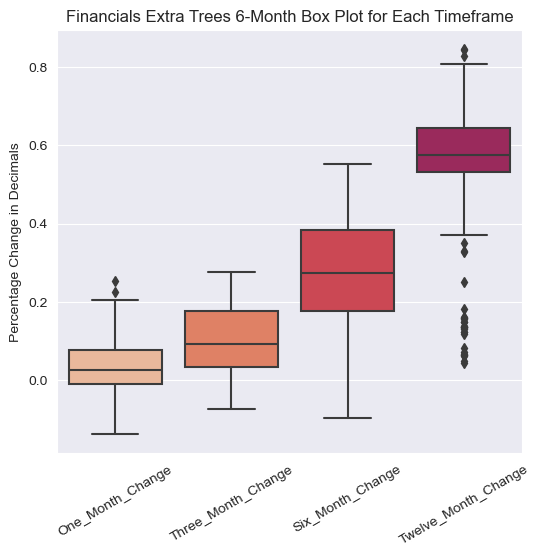

In [209]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Financials[16], "XLF", cat=1, box=True)[["Six_Month_Change"]]

Six_Month_Change
count       1188.000000
mean           0.046890
std            0.166803
min           -0.363654
25%           -0.062210
50%            0.047514
75%            0.136631
max            0.552720

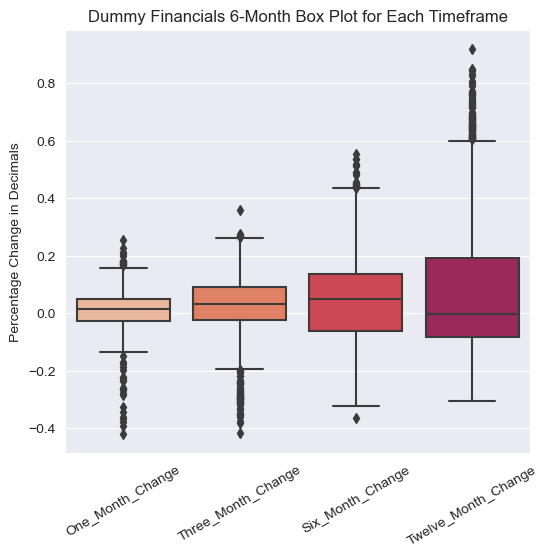

In [208]:
# Dummy comparison
describe_predictions(Financials[13], "XLF", cat=1, box=True)[["Six_Month_Change"]]

### Comparison of Dummy Confusion Matrix to the Best Model

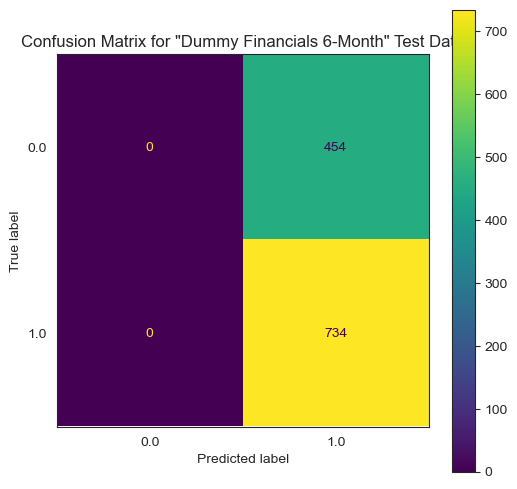

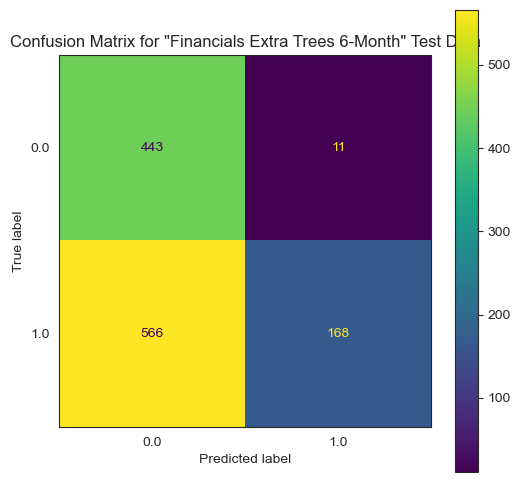

In [210]:
# Shows the best model's predictions and the dummy for that particular time horizon
Financials[13].confusion_matrix(), Financials[16].confusion_matrix();

### Feature Importances

In [211]:
# Feature Importances for each time-horizon's best model
print_feature_importances(8, 12, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
('Month_3', 0.0818)
('Month_1', 0.0746)
('cycle_year_4', 0.0734)
('Month_8', 0.0623)
('Quarter_4', 0.0435)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0634)
('ATR', 0.0585)
('Interest_Rates', 0.0447)
('one_up_bollinger_band', 0.0398)
('lowest_bollinger_band', 0.0384)
****************************************
Top 5 Feature Importance(s):
('cycle_year_3', 0.0694)
('GDP_Filled', 0.0693)
('ATR', 0.059)
('Interest_Rates', 0.0544)
('garman_klass_vol', 0.0443)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.1103)
('Interest_Rates', 0.0669)
('ATR', 0.061)
('Low', 0.0581)
('garman_klass_vol', 0.0581)


<hr style="border: 4px solid black">

# Industrials XLI

The trend of short term timeframes being influenced by non-macro/technical indicators continued, as did the trend of longer term models being influenced by macro-economic conditions.

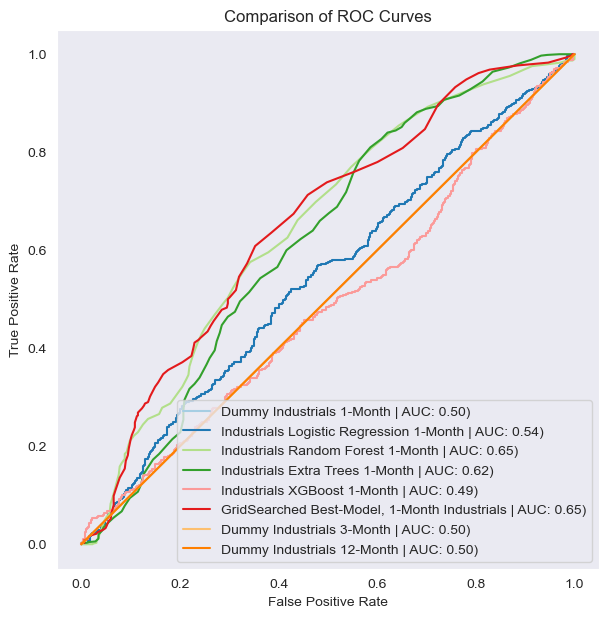

In [215]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Industrials[0], Industrials[1], Industrials[2],Industrials[3],Industrials[4],Industrials[5], \
                Industrials[6], Industrials[23]])

### Best Models for the Sector

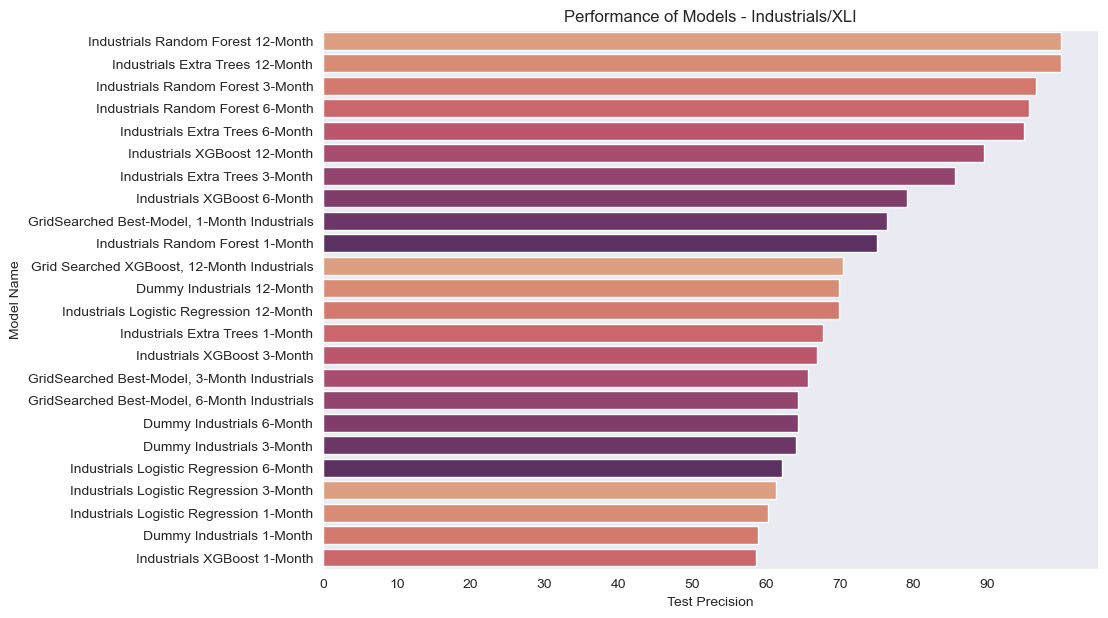

In [216]:
# Plotting the Test Precision of every model for this ETF

plot_test_precision(Industrials_df, "Industrials/XLI", num_include=30)

In [218]:
# These were the models with the highest precision score for this ETF

Industrials_df.sort_values(by='test_prec', ascending=False)[2:7]

name  train_accuracy  train_prec  \
8   Industrials Random Forest 3-Month        0.488748    0.793511   
14  Industrials Random Forest 6-Month        0.425790    0.850129   
15    Industrials Extra Trees 6-Month        0.580278    0.908441   
22       Industrials XGBoost 12-Month        0.397724    0.689528   
9     Industrials Extra Trees 3-Month        0.549431    0.815025   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
8       0.437685  0.464331       0.935639       0.500000   0.966480   
14      0.323543  0.431109       1.046989       0.497475   0.956284   
15      0.531628  0.580356       0.922551       0.494108   0.950276   
22      0.416390  0.461026       3.215357       0.446970   0.895455   
9       0.531659  0.535306       0.917476       0.500842   0.855932   

    test_recall   test_f1  test_logloss       AUC  
8      0.227332  0.368085      0.914622  0.741533  
14     0.229058  0.369588      1.026597  0.654387  
15     0.225131  0.364021      0.786628  0.614192  
22     0.237064  0.374881      2.019051  0.634280  
9      0.265440  0.405216      0.721921  0.755914

### How did our model perform when predicting "BUY"?
The best model was a 3-month RandomForestClassifier model. As you can see below, looking only at the "Three_Month_Change" column, the `median return on predicted "buys" for 3-Months was 13%. The worst outcome on a predicted "buy" was a loss of 6.3%.` The dummy model mean gains were over 10% worse, so this model once again made substantial improvements over the dummy. 

Three_Month_Change
count          179.000000
mean             0.129899
std              0.077272
min             -0.062662
25%              0.077702
50%              0.129482
75%              0.172169
max              0.422115

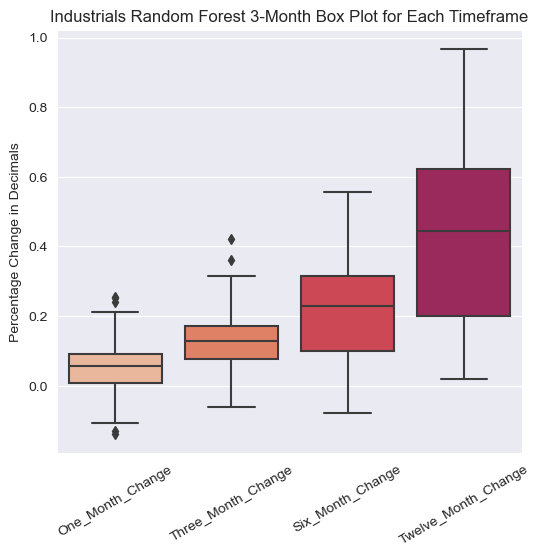

In [222]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Industrials[8], "XLI", cat=1, box=True)[["Three_Month_Change"]]

Three_Month_Change
count         1188.000000
mean             0.025648
std              0.104574
min             -0.401429
25%             -0.021145
50%              0.025000
75%              0.099026
max              0.422115

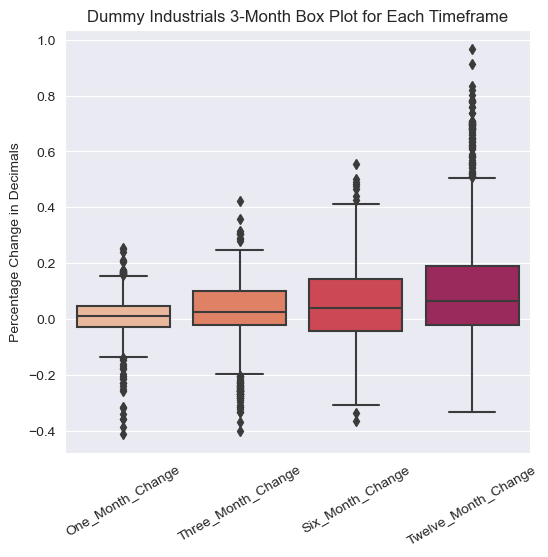

In [221]:
# Dummy Comparison
describe_predictions(Industrials[6], "XLI", cat=1, box=True)[["Three_Month_Change"]]

### Comparison of Dummy Confusion Matrix to the Best Model

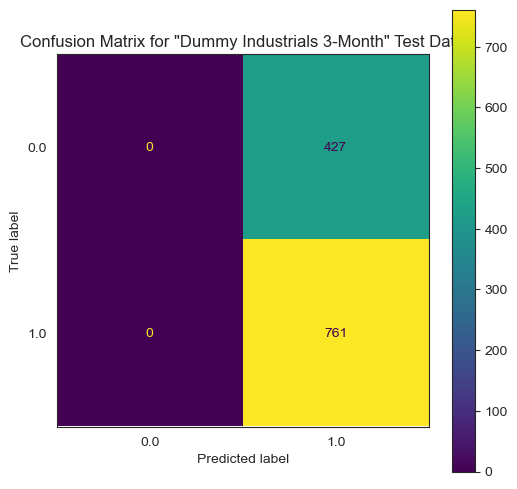

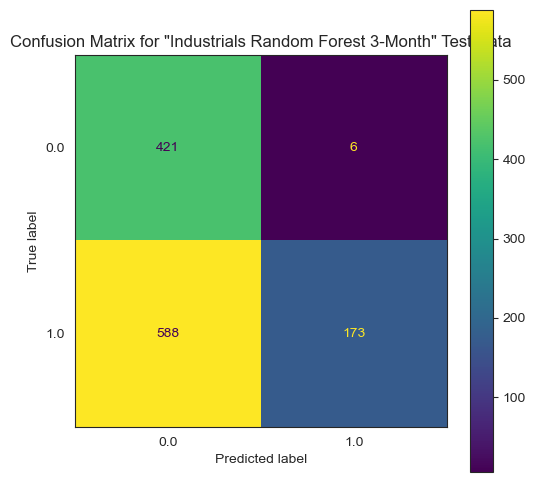

In [223]:
# Shows the best model's predictions and the dummy for that particular time horizon
Industrials[6].confusion_matrix(), Industrials[8].confusion_matrix();

### Feature Importances

In [224]:
# Feature Importances for each time-horizon's best model
print_feature_importances(12, 16, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
('ATR', 0.0562)
('one_up_bollinger_band', 0.0531)
('20_day_SMA', 0.0514)
('lower_bollinger_band', 0.0499)
('upper_bollinger_band', 0.0497)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0596)
('Interest_Rates', 0.0471)
('one_up_bollinger_band', 0.0412)
('lower_bollinger_band', 0.0396)
('20_day_SMA', 0.0395)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0852)
('Interest_Rates', 0.062)
('garman_klass_vol', 0.0491)
('cycle_year_3', 0.0491)
('cycle_year_4', 0.047)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.1487)
('Month_9', 0.1147)
('Quarter_1', 0.0999)
('Interest_Rates', 0.0796)
('upper_bollinger_band', 0.0622)


<hr style="border: 4px solid black">

# Technology XLK

A 3-Month model performed the best for this sector. Other interesting observations are that the feature importances were more eratic than previous sectors. This is indicative of the volatility of the data for this sector. 

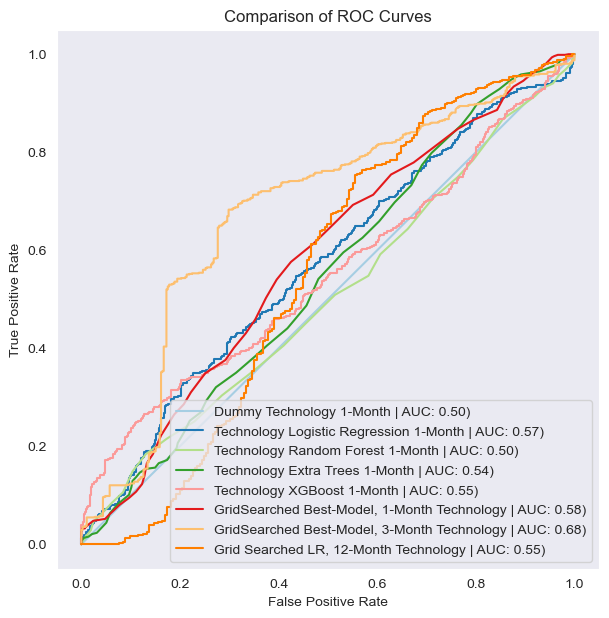

In [235]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Technology[0], Technology[1], Technology[2],Technology[3],Technology[4],Technology[5], \
                Technology[11], Technology[23]])

### Best Models for the Sector - That's right 0% Precision

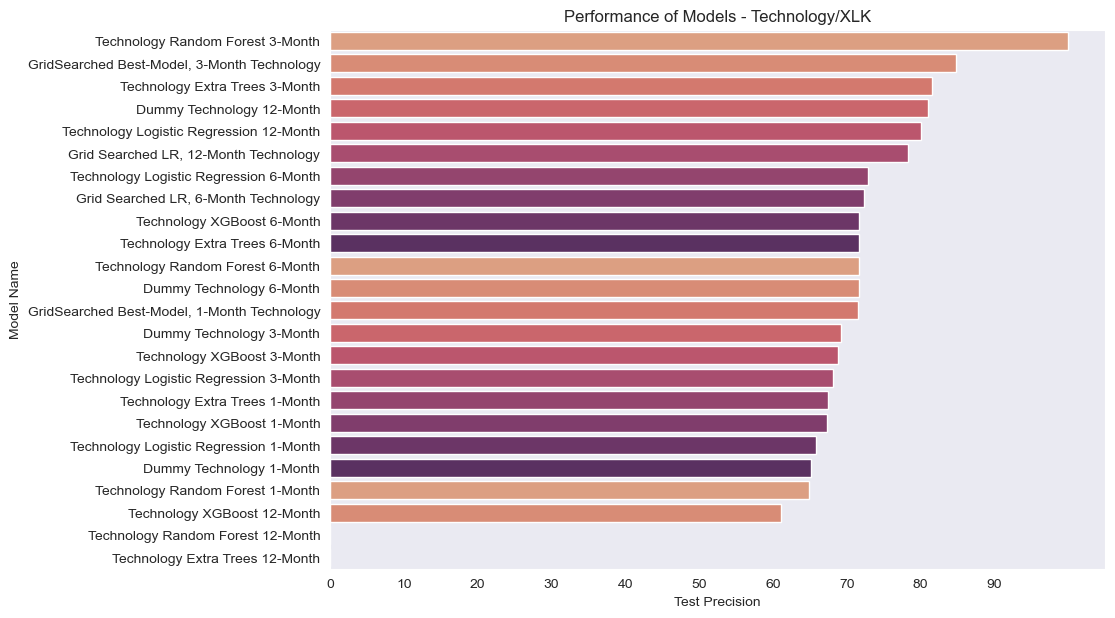

In [227]:
# Plotting the Test Precision of every model for this ETF

plot_test_precision(Technology_df, "Technology/XLK", num_include=30)

In [229]:
# These were the models with the highest precision score for this ETF

Technology_df.sort_values(by='test_prec', ascending=False)[1:6]

name  train_accuracy  train_prec  \
11  GridSearched Best-Model, 3-Month Technology        0.609861    0.836354   
9                Technology Extra Trees 3-Month        0.600506    0.829887   
18                    Dummy Technology 12-Month        0.705689    0.670544   
19      Technology Logistic Regression 12-Month        0.333755    0.485533   
23        Grid Searched LR, 12-Month Technology        0.333249    0.487719   

    train_recall  train_f1  train_logloss  test_accuracy  test_prec  \
11      0.592195  0.654916       0.706309       0.621212   0.848598   
9       0.575523  0.643000       0.721289       0.476431   0.815047   
18      0.800000  0.716781      10.608044       0.810606   0.810606   
19      0.397198  0.346855       7.527831       0.310606   0.800000   
23      0.391455  0.345042       8.791662       0.323232   0.782918   

    test_recall   test_f1  test_logloss       AUC  
11     0.551640  0.668630      0.660141  0.679136  
9      0.315917  0.455342      0.756312  0.661927  
18     1.000000  0.895397      6.826450  0.500000  
19     0.199377  0.319202      4.506678  0.572493  
23     0.228453  0.353698      4.700029  0.550119

### How did our model perform when predicting "BUY"?
The best model was a 12-month model, based on the RandomForestClassifier and tuned using GridSearchCV. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 3-Months was 8.6%. The worst outcome on a predicted "buy" was a loss of 22.8%.` Mean and median performance was better than the dummy, but we did have a smaller max gain.

Three_Month_Change
count          535.000000
mean             0.077828
std              0.088489
min             -0.228193
25%              0.028427
50%              0.085725
75%              0.125320
max              0.392702

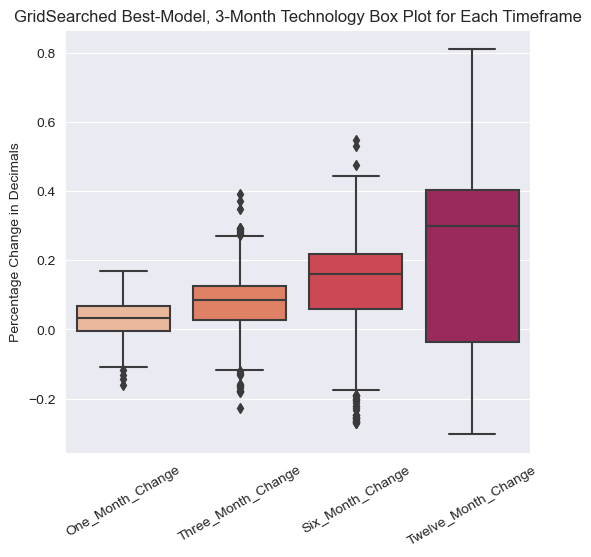

In [232]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Technology[11], "XLK", cat=1, box=True)[["Three_Month_Change"]]

Three_Month_Change
count         1188.000000
mean             0.044580
std              0.107829
min             -0.228193
25%             -0.030683
50%              0.057766
75%              0.106297
max              0.490317

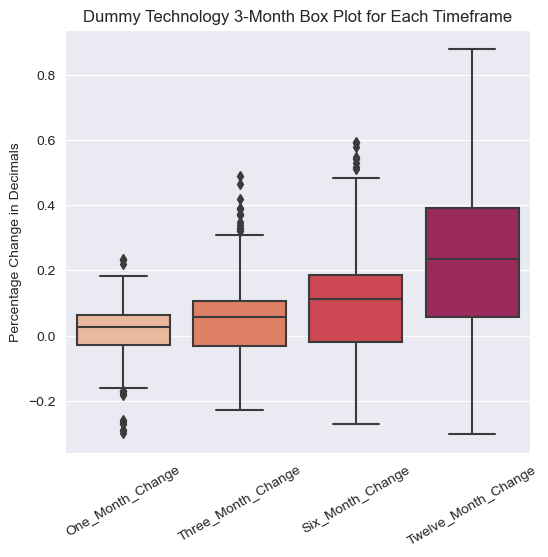

In [233]:
# Dummy Comparison
describe_predictions(Technology[6], "XLK", cat=1, box=True)[["Three_Month_Change"]]

### Comparison of Dummy Confusion Matrix to the Best Model

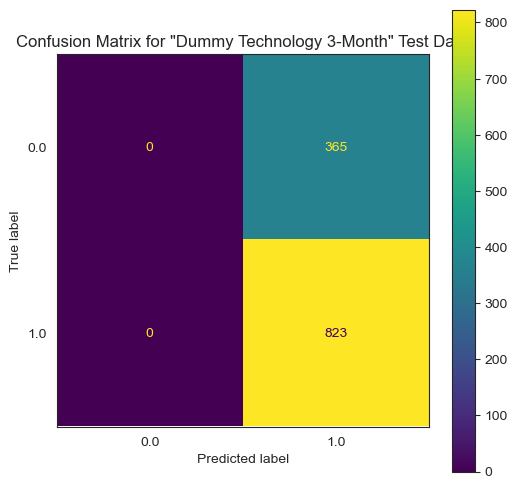

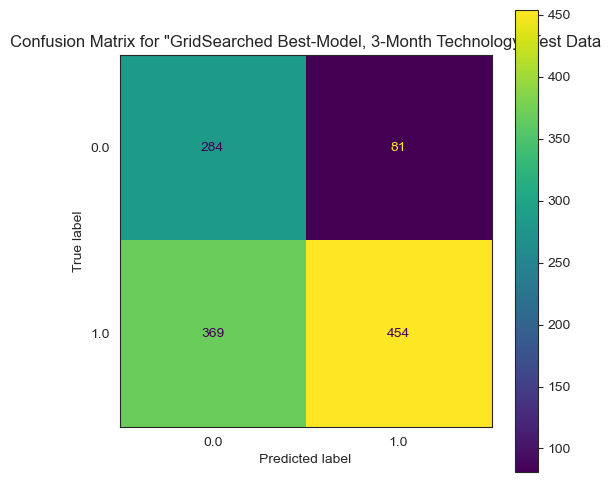

In [236]:
# Shows the best model's predictions and the dummy for that particular time horizon
Technology[6].confusion_matrix(), Technology[11].confusion_matrix();

### Feature Importances
6 and 12 month timeframes utilized logistic regression models. This has come to be a sign of volatile and unpredictable results.

In [237]:
# Feature Importances for each time-horizon's best model
print_feature_importances(16, 20, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
('Interest_Rates', 0.0438)
('20_day_SMA', 0.0434)
('one_up_bollinger_band', 0.0431)
('ATR', 0.042)
('lowest_bollinger_band', 0.0417)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0815)
('Interest_Rates', 0.0525)
('cycle_year_4', 0.0492)
('cycle_year_3', 0.0425)
('Adj Close', 0.0392)
****************************************
Top 5 Feature Importance(s):
('Adj Close', 6.331)
('Close', -5.1981)
('High', -2.8302)
('GDP_Filled', -2.1847)
('Open', 1.9299)
****************************************
Top 5 Feature Importance(s):
('Close', -6.3672)
('GDP_Filled', -4.9327)
('lowest_bollinger_band', 3.9153)
('Adj Close', 3.6267)
('High', -3.3174)


<hr style="border: 4px solid black">

# Staples XLP

We are back to longterm predictions being the most accurate. The sector's best model was a 12 month Logistic Regression model. This is the first time logistic regression has been featured as a sector representative. The data in this sector, particularly over a 12-month timeframe, is heavily imbalanced toward the positive class. This is in line with the perception of this sector as a whole. Staples have the reputation for being reliable investments with comparatively low volatility. 

#### One of the best looking ROC curves so far

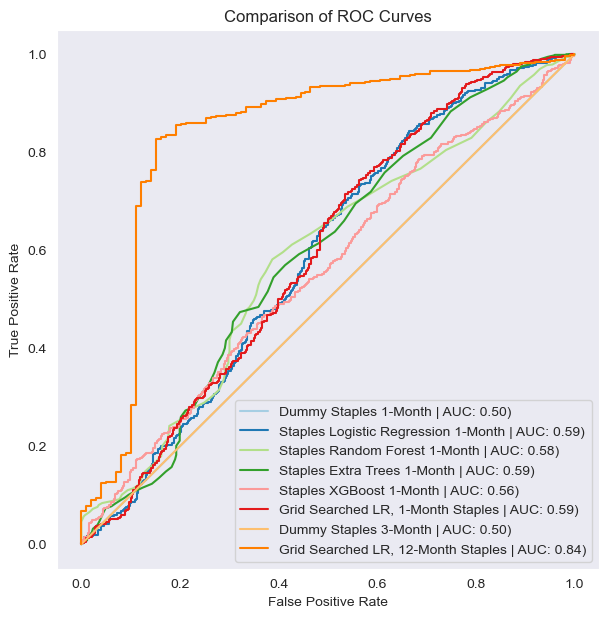

In [250]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Staples[0], Staples[1], Staples[2],Staples[3],Staples[4],Staples[5], \
                Staples[6], Staples[23]])

### Best Models for the Sector

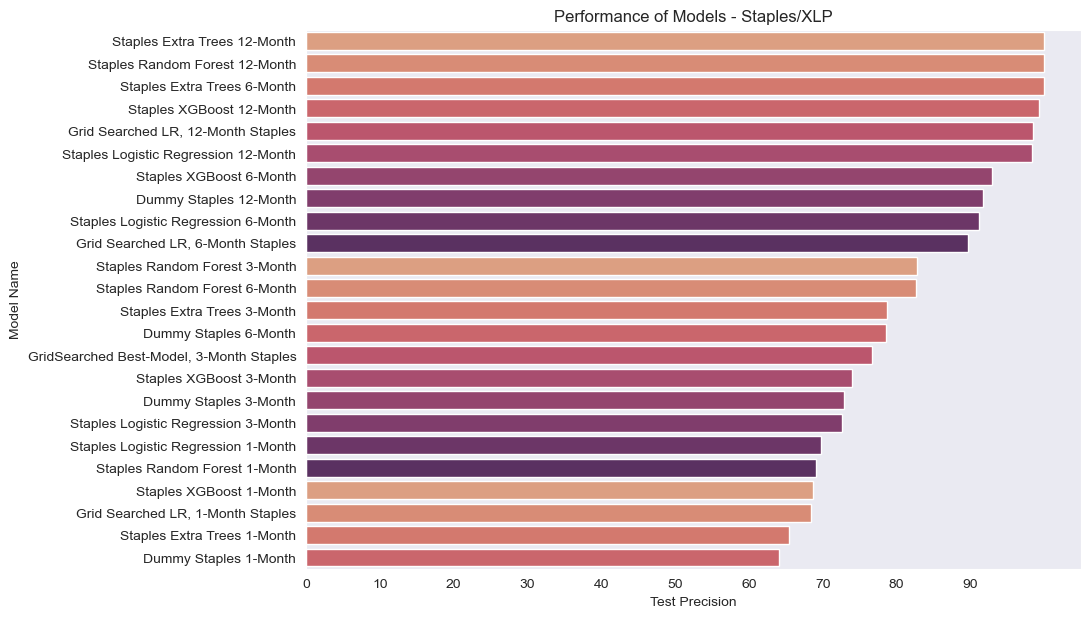

In [238]:
# Plotting the Test Precision of every model for this ETF

plot_test_precision(Staples_df, "Staples/XLP", num_include=30)

In [240]:
# These were the models with the highest precision score for this ETF

Staples_df.sort_values(by='test_prec', ascending=False)[4:9]

name  train_accuracy  train_prec  \
23    Grid Searched LR, 12-Month Staples        0.613906    0.947064   
19  Staples Logistic Regression 12-Month        0.588875    0.946635   
16               Staples XGBoost 6-Month        0.474842    0.838947   
18                Dummy Staples 12-Month        0.724399    0.696334   
13   Staples Logistic Regression 6-Month        0.573451    0.821671   

    train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
23      0.621605  0.684687       0.688552   0.985155     0.670340  0.797814   
19      0.600563  0.665279       0.702020   0.984190     0.685950  0.808442   
16      0.455912  0.518531       0.255892   0.929825     0.056806  0.107071   
18      0.800000  0.741708       0.916667   0.916667     1.000000  0.956522   
13      0.673091  0.664355       0.473064   0.911528     0.364416  0.520674   

    test_logloss       AUC  
23      1.192832  0.835453  
19      0.953197  0.830769  
16      4.129593  0.572259  
18      3.003638  0.500000  
13      1.973365  0.635967

### How did our model perform when predicting "BUY"?
The best model was a 12-month model, based on LogisticRegression and tuned using GridSearchCV. This is the first such instance of a logistic regression model being the best useful model for a sector. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 13.5%. The worst outcome on a predicted "buy" was a loss of 9.4%.` Mean and median gains for our model were both better than the dummy.

Twelve_Month_Change
count           741.000000
mean              0.134275
std               0.072887
min              -0.093764
25%               0.084290
50%               0.135207
75%               0.178977
max               0.416064

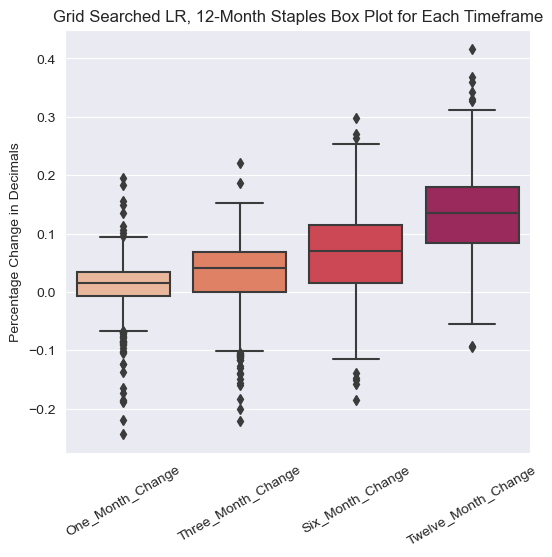

In [253]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Staples[23], "XLP", cat=1, box=True)[["Twelve_Month_Change"]]

Twelve_Month_Change
count          1188.000000
mean              0.102779
std               0.079621
min              -0.093764
25%               0.035425
50%               0.097922
75%               0.163782
max               0.416064

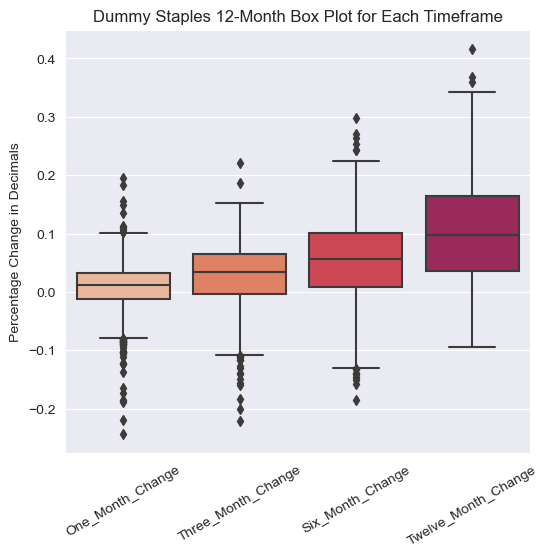

In [254]:
# Dummy Comparison
describe_predictions(Staples[18], "XLP", cat=1, box=True)[["Twelve_Month_Change"]]

### Comparison of Dummy Confusion Matrix to the Best Model

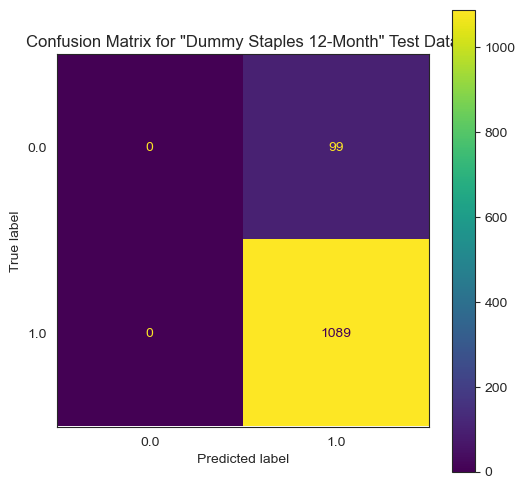

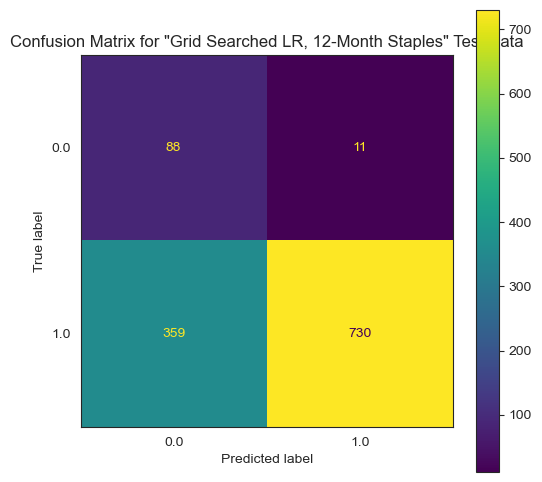

In [255]:
# Shows the best model's predictions and the dummy for that particular time horizon
Staples[18].confusion_matrix(), Staples[23].confusion_matrix();

### Feature Importances

In [256]:
# Feature Importances for each time-horizon's best model
print_feature_importances(20, 24, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
('garman_klass_vol', 1.7631)
('upper_bollinger_band', 1.3106)
('GDP_Filled', -1.0419)
('Close', -1.017)
('one_up_bollinger_band', 0.8575)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0921)
('Interest_Rates', 0.0701)
('garman_klass_vol', 0.0673)
('High', 0.0607)
('ATR', 0.0592)
****************************************
Top 5 Feature Importance(s):
('garman_klass_vol', 4.1796)
('GDP_Filled', -1.9378)
('Close', -1.1738)
('High', -1.0635)
('Interest_Rates', 0.8226)
****************************************
Top 5 Feature Importance(s):
('garman_klass_vol', 9.8323)
('GDP_Filled', -8.1962)
('Close', -8.1438)
('Adj Close', 6.1527)
('upper_bollinger_band', 5.0925)


<hr style="border: 4px solid black">

# Utilities XLU

The best model for this sector was again a 6-month model. The erratic dark green ROC curve below is actually, improbably this sector's best model. 

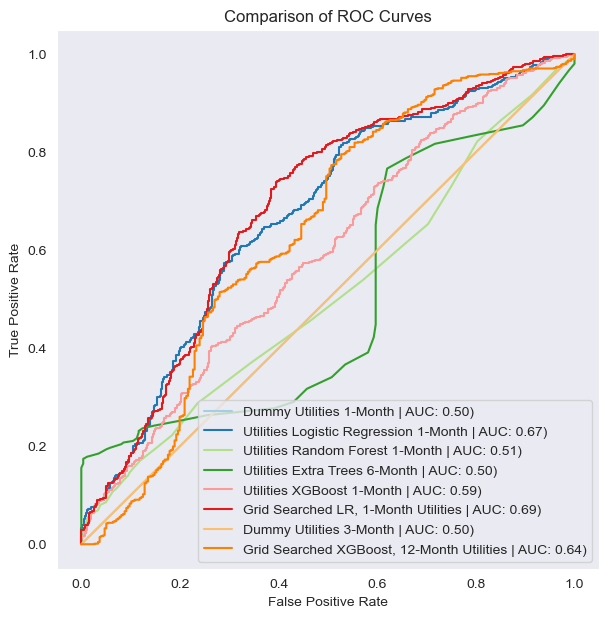

In [270]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Utilities[0], Utilities[1], Utilities[2],Utilities[15],Utilities[4],Utilities[5], \
                Utilities[6], Utilities[23]])

### Best Models for the Sector

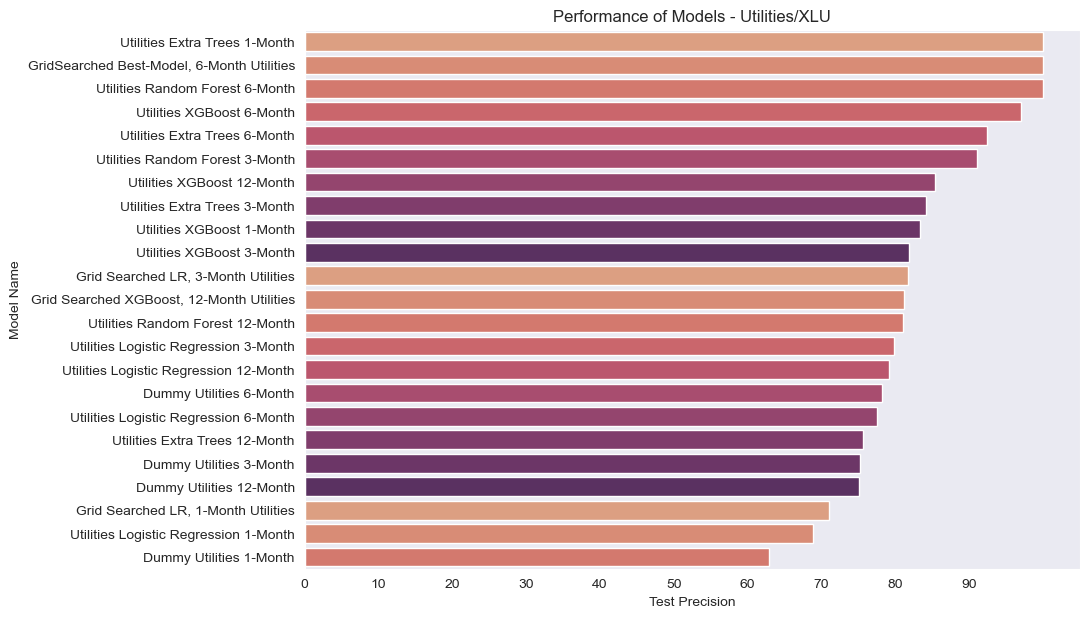

In [272]:
# Plotting the Test Precision of every model for this ETF

plot_test_precision(Utilities_df, "Utilities/XLU", num_include=-1)

In [263]:
# These were the models with the highest precision score for this ETF

Utilities_df.sort_values(by='test_prec', ascending=False)[4:9]

name  train_accuracy  train_prec  train_recall  \
15    Utilities Extra Trees 6-Month        0.558786    0.864044      0.547521   
8   Utilities Random Forest 3-Month        0.519090    0.671392      0.609332   
22       Utilities XGBoost 12-Month        0.501138    0.910417      0.537615   
9     Utilities Extra Trees 3-Month        0.541593    0.713039      0.629322   
4         Utilities XGBoost 1-Month        0.515550    0.654395      0.581357   

    train_f1  train_logloss  test_accuracy  test_prec  test_recall   test_f1  \
15  0.577545       0.728913       0.358586   0.924242     0.196774  0.324468   
8   0.555249       0.832238       0.325758   0.911504     0.115213  0.204568   
22  0.576841       2.023900       0.808923   0.853348     0.900224  0.876159   
9   0.617432       0.712508       0.316498   0.841667     0.112975  0.199211   
4   0.586978       1.763233       0.408249   0.833333     0.073628  0.135301   

    test_logloss       AUC  
15      1.080193  0.501673  
8       1.492251  0.533627  
22      0.586135  0.825459  
9       1.020218  0.483197  
4       2.974106  0.592095

### How did our model perform when predicting "BUY"?
The best model was a 6-month ExtraTreesClassifier model. As you can see below, looking only at the "Six_Month_Change" column, the `median return on predicted "buys" for 6-Months was 9.5%. The worst outcome on a predicted "buy" was a loss of 10.7%.` The statistical profile of our model is vastly superior to the dummy model. 

Six_Month_Change
count        198.000000
mean           0.089442
std            0.061368
min           -0.107152
25%            0.055043
50%            0.094767
75%            0.121281
max            0.293176

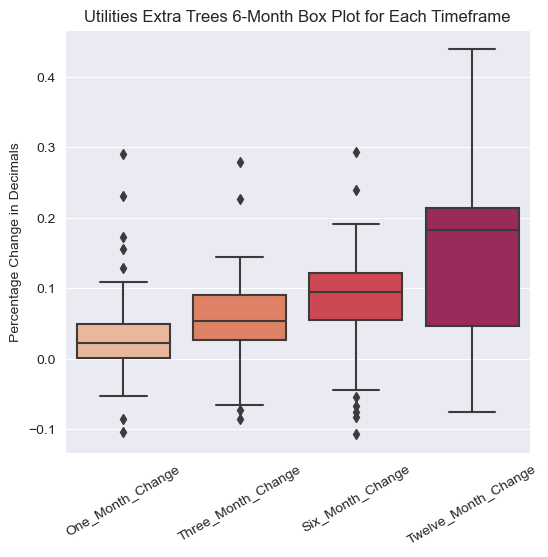

In [266]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Utilities[15], "XLU", cat=1, box=True)[["Six_Month_Change"]]

Six_Month_Change
count       1188.000000
mean           0.052622
std            0.083688
min           -0.284060
25%            0.014634
50%            0.069638
75%            0.106767
max            0.293176

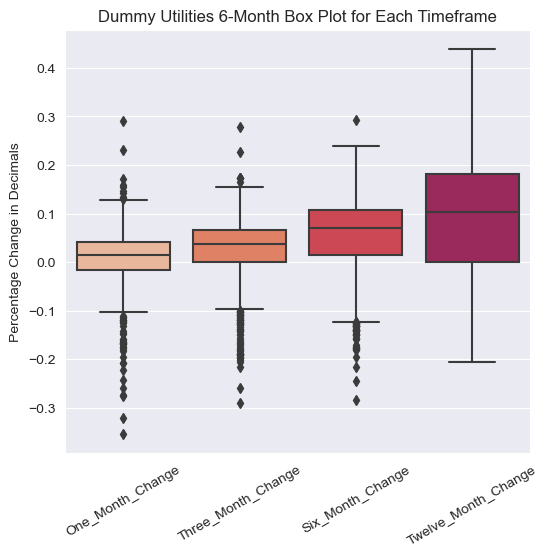

In [267]:
# Dummy Comparison
describe_predictions(Utilities[12], "XLU", cat=1, box=True)[["Six_Month_Change"]]

### Comparison of Dummy Confusion Matrix to the Best Model

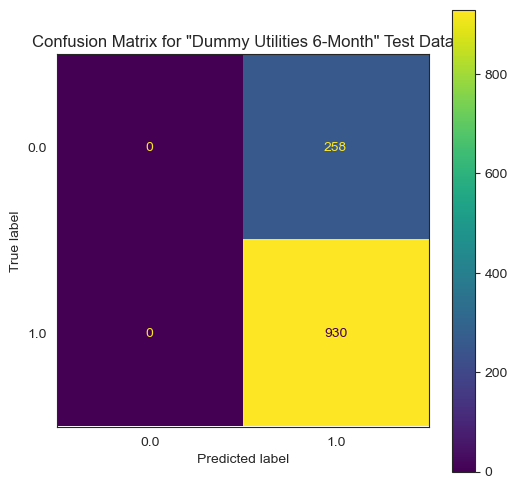

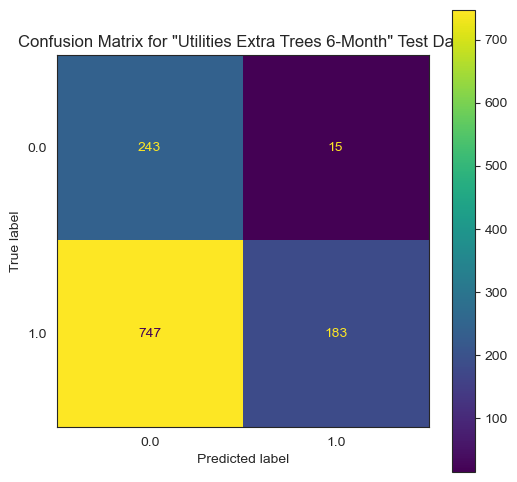

In [268]:
# Shows the best model's predictions and the dummy for that particular time horizon
Utilities[12].confusion_matrix(), Utilities[15].confusion_matrix();

### Feature Importances

In [273]:
# Feature Importances for each time-horizon's best model
print_feature_importances(24, 28, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 2.327)
('Interest_Rates', 1.0346)
('Adj Close', 1.0156)
('Close', -0.6696)
('Low', -0.645)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 2.4585)
('Interest_Rates', 1.8494)
('Adj Close', 1.7224)
('Open', -1.1802)
('High', -1.1608)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0805)
('garman_klass_vol', 0.0566)
('cycle_year_4', 0.0482)
('Interest_Rates', 0.0476)
('ATR', 0.0455)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.2906)
('Adj Close', 0.0712)
('High', 0.0626)
('upper_bollinger_band', 0.0593)
('Month_9', 0.0578)


<hr style="border: 4px solid black">

# Health Care XLV

Feature importance trends continue to be in place, with GDP and Interest Rates dominating longer term timeframes.  
Our model was also once again able to improve on the performance of the dummy.

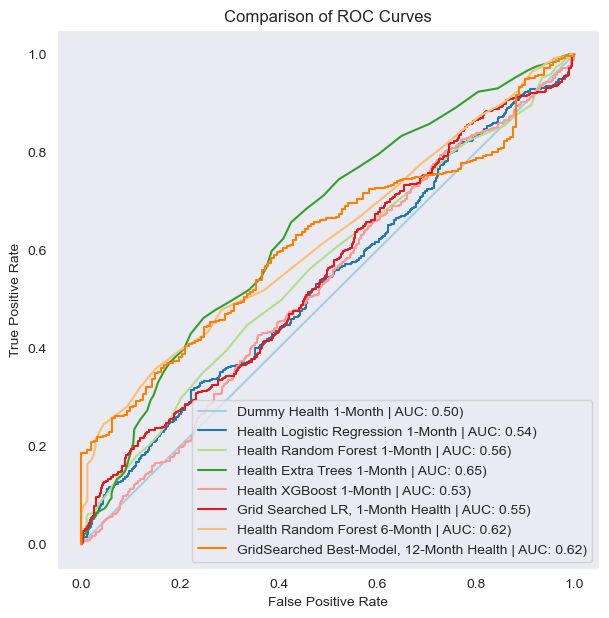

In [283]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Health[0], Health[1], Health[2],Health[3],Health[4],Health[5], \
                Health[14], Health[23]])

### Best Models for the Sector

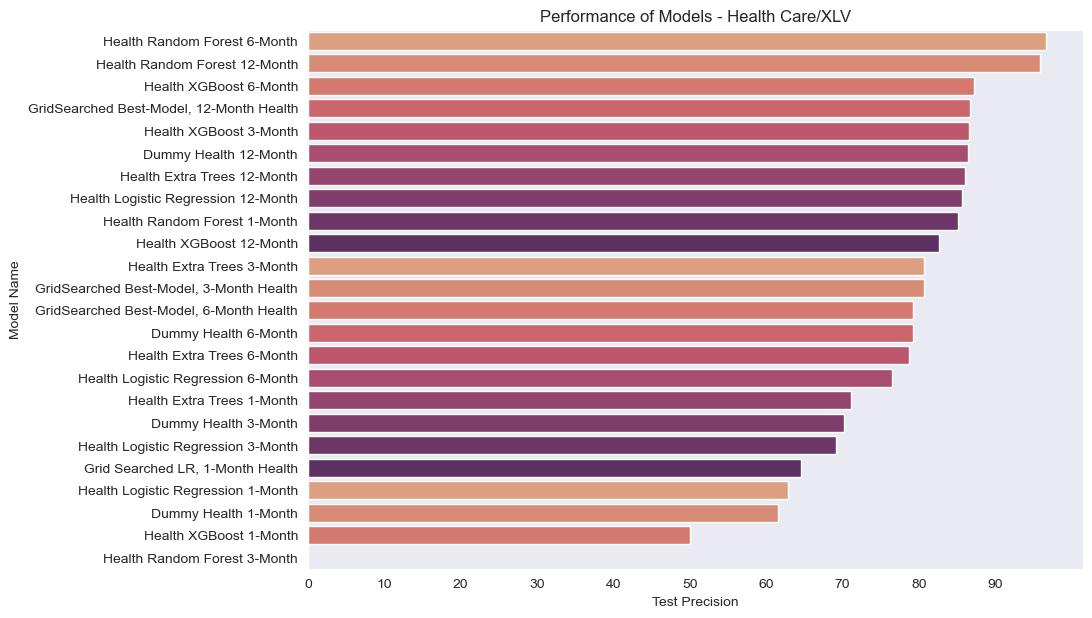

In [275]:
# Plotting the Test Precision of every model for this ETF

plot_test_precision(Health_df, "Health Care/XLV", num_include=30)

In [276]:
# These were the models with the highest precision score for this ETF

Health_df.sort_values(by='test_prec', ascending=False)[:5]

name  train_accuracy  train_prec  \
14              Health Random Forest 6-Month        0.462705    0.825016   
20             Health Random Forest 12-Month        0.640961    0.907582   
16                    Health XGBoost 6-Month        0.490518    0.766551   
23  GridSearched Best-Model, 12-Month Health        0.677370    0.916384   
10                    Health XGBoost 3-Month        0.479899    0.764065   

    train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
14      0.401086  0.422490       0.370370   0.966346     0.213376  0.349565   
20      0.572817  0.633259       0.430135   0.958115     0.356378  0.519517   
16      0.465549  0.523609       0.441077   0.871658     0.346072  0.495441   
23      0.620282  0.685663       0.856061   0.867067     0.984421  0.922025   
10      0.446311  0.491550       0.357744   0.865979     0.100719  0.180451   

    test_logloss       AUC  
14      0.749420  0.620952  
20      0.692242  0.636803  
16      1.833425  0.593259  
23      0.519852  0.616479  
10      3.693161  0.539196

### How did our model perform when predicting "BUY"?
The best model was a 6-month RandomForestClassifier. As you can see below, looking only at the "Six_Month_Change" column, the `median return on predicted "buys" for 6-Months was 8.9%. The worst outcome on a predicted "buy" was a loss of 4.2%.`The mean and median returns for our model are better than both for the dummy model.

Six_Month_Change
count        208.000000
mean           0.094231
std            0.070821
min           -0.041772
25%            0.039094
50%            0.088597
75%            0.123188
max            0.376824

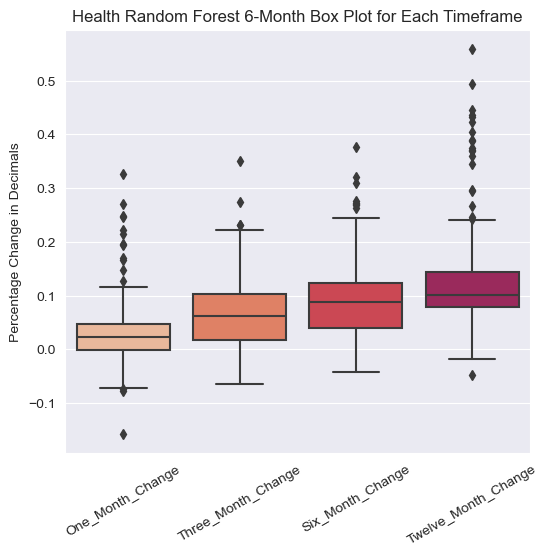

In [280]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Health[14], "XLV", cat=1, box=True)[["Six_Month_Change"]]

Six_Month_Change
count       1188.000000
mean           0.060881
std            0.072347
min           -0.171864
25%            0.006412
50%            0.066347
75%            0.112041
max            0.376824

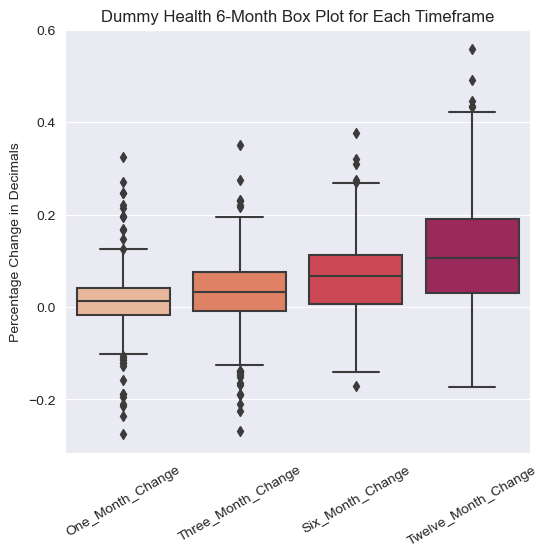

In [279]:
# Dummy Comparison
describe_predictions(Health[12], "XLV", cat=1, box=True)[["Six_Month_Change"]]

### Comparison of Dummy Confusion Matrix to the Best Model

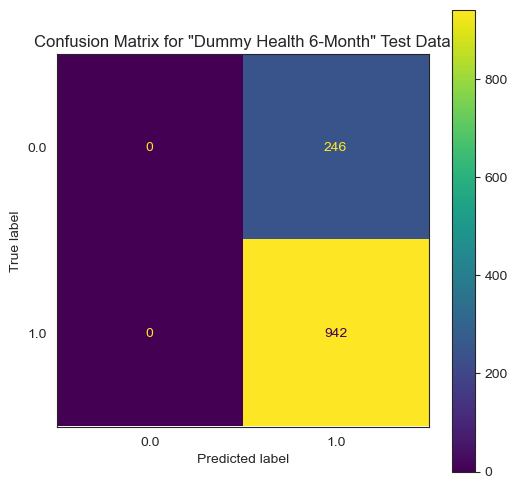

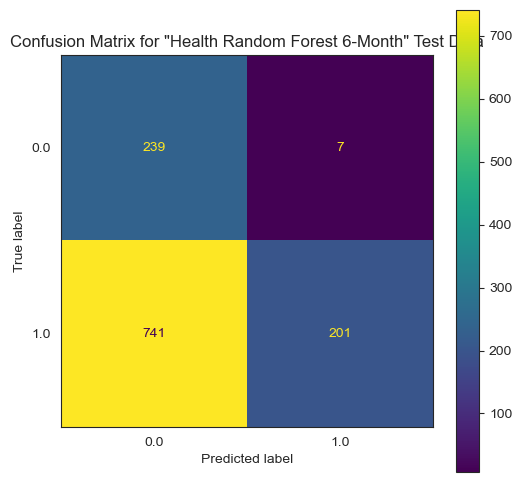

In [281]:
# Shows the best model's predictions and the dummy for that particular time horizon
Health[12].confusion_matrix(), Health[14].confusion_matrix();

### Feature Importances

In [282]:
# Feature Importances for each time-horizon's best model
print_feature_importances(28, 32, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
('Close', -0.7722)
('garman_klass_vol', 0.7228)
('upper_bollinger_band', 0.6685)
('Adj Close', 0.5264)
('Month_10', -0.5216)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0547)
('lowest_bollinger_band', 0.0461)
('20_day_SMA', 0.044)
('lower_bollinger_band', 0.0435)
('Close', 0.0428)
****************************************
Top 5 Feature Importance(s):
('GDP_Filled', 0.0888)
('Interest_Rates', 0.0705)
('Close', 0.0583)
('High', 0.0537)
('ATR', 0.049)
****************************************
Top 5 Feature Importance(s):
('Interest_Rates', 0.1109)
('GDP_Filled', 0.1058)
('garman_klass_vol', 0.0642)
('High', 0.0522)
('Close', 0.0468)


<hr style="border: 4px solid black">

# Consumer Discretionary XLY

All feature trends remained in place, and our model was again able to outpace the dummy.

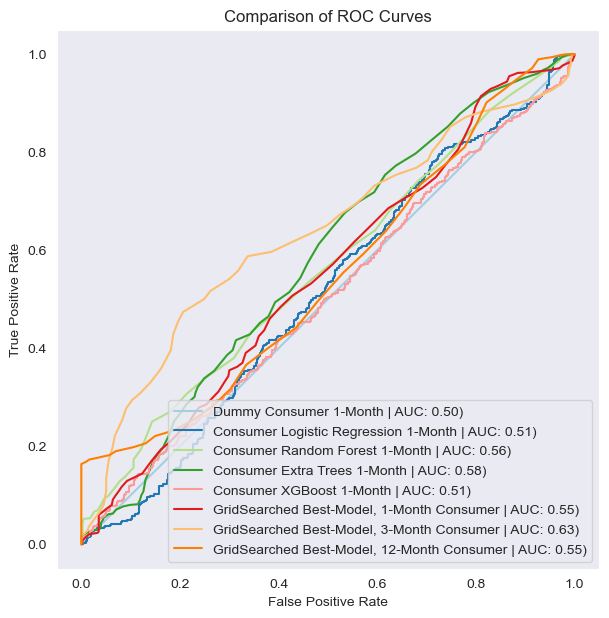

In [298]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Consumer_Disc[0], Consumer_Disc[1], Consumer_Disc[2],Consumer_Disc[3],Consumer_Disc[4],Consumer_Disc[5], \
                Consumer_Disc[11], Consumer_Disc[23]])

### Best Models for the Sector

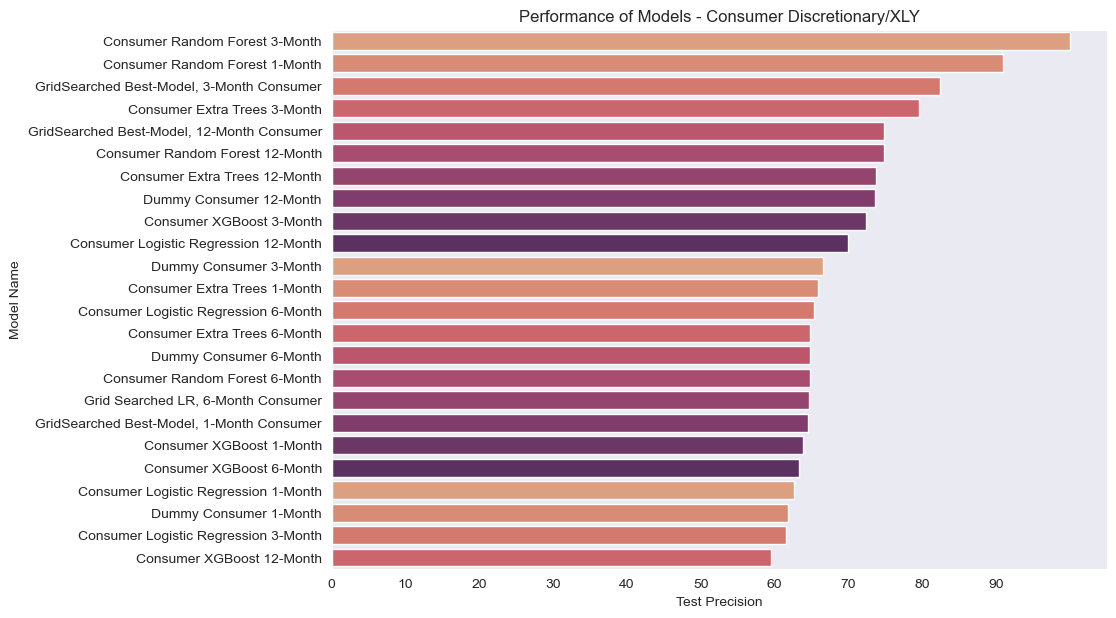

In [285]:
# Plotting the Test Precision of every model for this ETF

plot_test_precision(Consumer_Disc_df, "Consumer Discretionary/XLY", num_include=30)

In [289]:
# These were the models with the highest precision score for this ETF

Consumer_Disc_df.sort_values(by='test_prec', ascending=False)[2:7]

name  train_accuracy  train_prec  \
11   GridSearched Best-Model, 3-Month Consumer        0.580784    0.786494   
9                 Consumer Extra Trees 3-Month        0.559039    0.762418   
23  GridSearched Best-Model, 12-Month Consumer        0.613148    0.904434   
20             Consumer Random Forest 12-Month        0.613148    0.904434   
21               Consumer Extra Trees 12-Month        0.656637    0.883574   

    train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
11      0.511174  0.568732       0.507576   0.823899     0.331226  0.472498   
9       0.476567  0.540431       0.485690   0.796053     0.305942  0.442009   
23      0.587018  0.595741       0.622896   0.748252     0.734554  0.741339   
20      0.587018  0.595741       0.622896   0.748252     0.734554  0.741339   
21      0.605845  0.654974       0.737374   0.736931     1.000000  0.848544   

    test_logloss       AUC  
11      0.769674  0.632460  
9       0.801115  0.627140  
23      0.626359  0.546036  
20      0.626359  0.546036  
21      0.600953  0.433376

### How did our model perform when predicting "BUY"?
The best model was a 3-month GridSearch tuned ExtraTreesClassifier. As you can see below, looking only at the "Three_Month_Change" column, the `median return on predicted "buys" for 3-Months was 8%. The worst outcome on a predicted "buy" was a loss of 21%.` Once again, the profile of our model is much better than the dummy. 

Three_Month_Change
count          318.000000
mean             0.079640
std              0.118299
min             -0.209428
25%              0.029684
50%              0.079980
75%              0.129705
max              0.481793

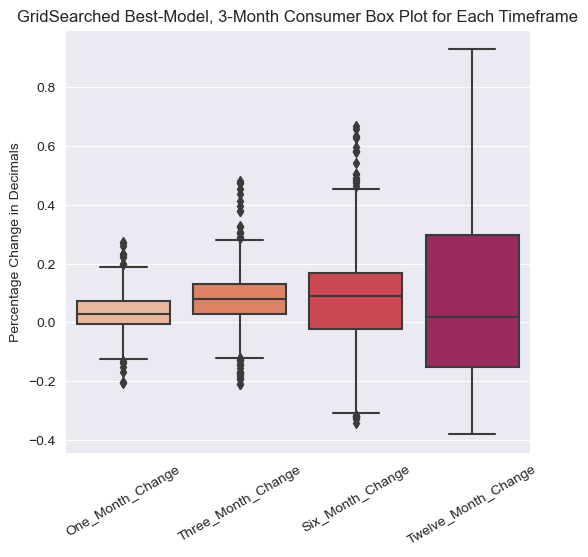

In [292]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Consumer_Disc[11], "XLY", cat=1, box=True)[["Three_Month_Change"]]

Three_Month_Change
count         1188.000000
mean             0.024874
std              0.112722
min             -0.294982
25%             -0.033135
50%              0.042166
75%              0.086006
max              0.481793

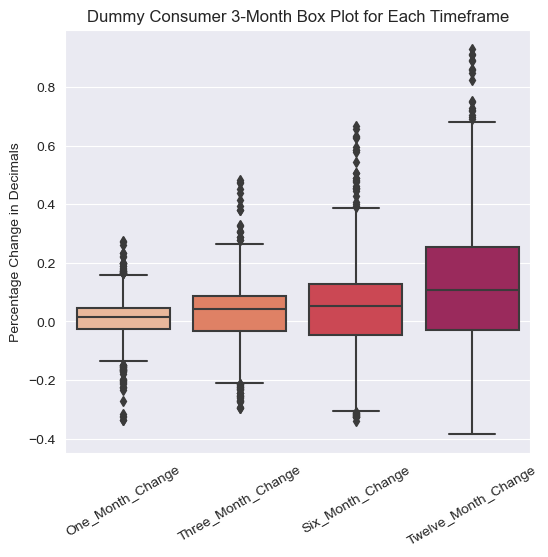

In [293]:
# Dummy Comparison
describe_predictions(Consumer_Disc[6], "XLY", cat=1, box=True)[["Three_Month_Change"]]

### Comparison of Dummy Confusion Matrix to the Best Model

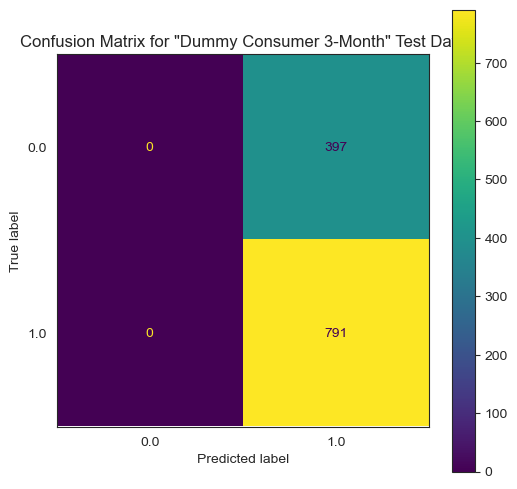

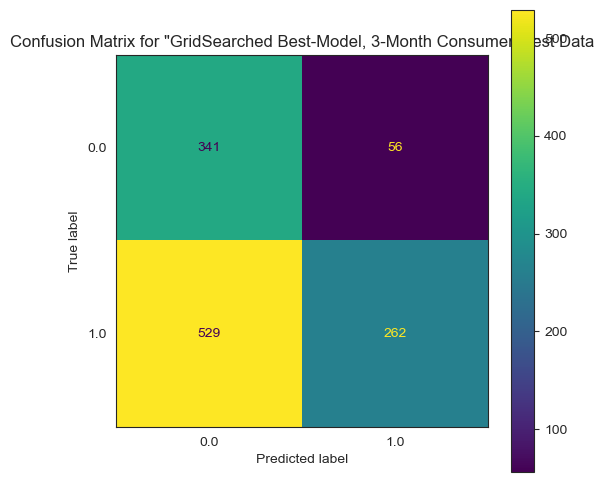

In [296]:
# Shows the best model's predictions and the dummy for that particular time horizon
Consumer_Disc[6].confusion_matrix(), Consumer_Disc[11].confusion_matrix();

### Feature Importances

In [299]:
# Feature Importances for each time-horizon's best model
print_feature_importances(32, 36, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
('MACD', 0.0453)
('one_up_bollinger_band', 0.0447)
('lower_bollinger_band', 0.0437)
('upper_bollinger_band', 0.0437)
('20_day_SMA', 0.0432)
****************************************
Top 5 Feature Importance(s):
('Interest_Rates', 0.0603)
('GDP_Filled', 0.0507)
('one_up_bollinger_band', 0.0419)
('lowest_bollinger_band', 0.041)
('20_day_SMA', 0.0407)
****************************************
Top 5 Feature Importance(s):
('Adj Close', 5.3302)
('Close', -4.546)
('High', -3.9792)
('upper_bollinger_band', 3.8799)
('Low', -2.9533)
****************************************
Top 5 Feature Importance(s):
('Interest_Rates', 0.1473)
('GDP_Filled', 0.0954)
('upper_bollinger_band', 0.0641)
('garman_klass_vol', 0.0543)
('Close', 0.0506)


<hr style="border: 4px solid black">

# Real Estate XLRE

This sector proved to be difficult to predict. All scores were remarkably low, likely due to the smaller sample of data for this sector. Even with little data, GDP and interest rates were still influential features.

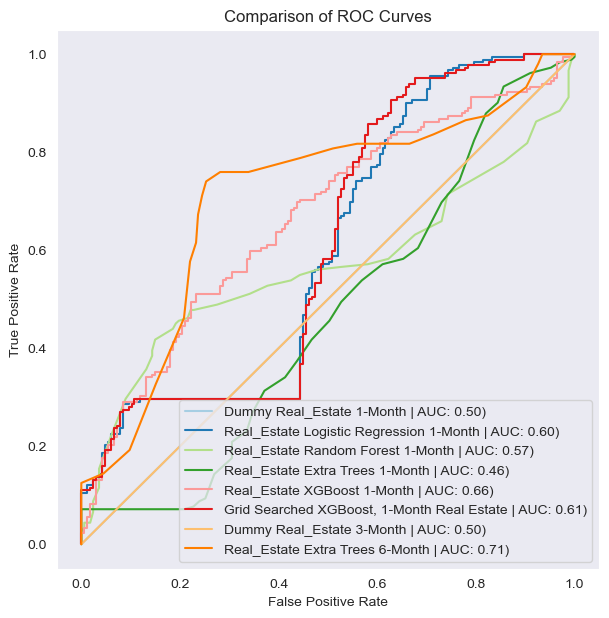

In [300]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Real_Estate[0], Real_Estate[1], Real_Estate[2],Real_Estate[3],Real_Estate[4],Real_Estate[5], \
                Real_Estate[6], Real_Estate[15]])

# 15 was the best model of this sector

### Best Models for the Sector

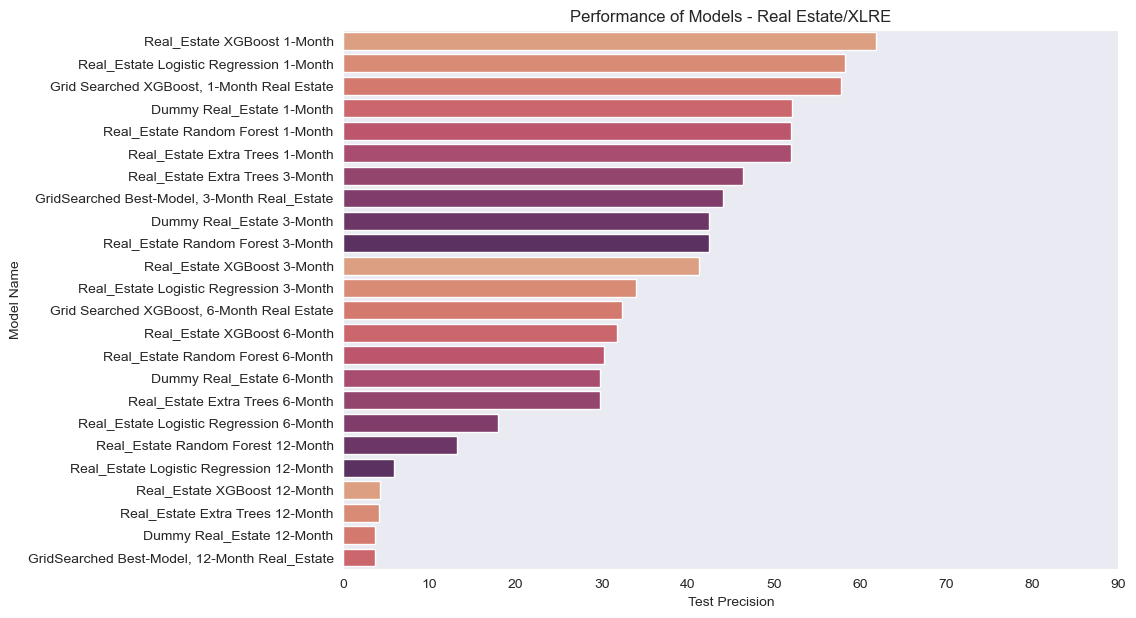

In [301]:
# Plotting the Test Precision of every model for this ETF

plot_test_precision(Real_Estate_df, "Real Estate/XLRE", num_include=30)

In [302]:
# These were the models with the highest precision score for this ETF

Real_Estate_df.sort_values(by='test_prec', ascending=False)[:5]

name  train_accuracy  train_prec  \
4                 Real_Estate XGBoost 1-Month        0.505172    0.670998   
1     Real_Estate Logistic Regression 1-Month        0.585345    0.733793   
5  Grid Searched XGBoost, 1-Month Real Estate        0.549138    0.842132   
0                   Dummy Real_Estate 1-Month        0.652586    0.652586   
2           Real_Estate Random Forest 1-Month        0.500862    0.661925   

   train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
4      0.503405  0.558020       0.621777   0.619048     0.714286  0.663265   
1      0.589295  0.583283       0.581662   0.582569     0.697802  0.635000   
5      0.464999  0.472996       0.570201   0.577670     0.653846  0.613402   
0      1.000000  0.789079       0.521490   0.521490     1.000000  0.685499   
2      0.489533  0.520656       0.518625   0.520115     0.994505  0.683019   

   test_logloss       AUC  
4      0.939186  0.664802  
1      1.518962  0.601829  
5      1.766349  0.610285  
0     17.247250  0.500000  
2      0.752472  0.565473

### How did our model perform when predicting "BUY"?
The best model was a 1-month XGBoost model. As you can see below, looking only at the "One_Month_Change" column, the `median return on predicted "buys" for 1-Month was 1.9%. The worst outcome on a predicted "buy" was a loss of 16.6%.` While our model only produced a mean return of 0.8%, the dummy model produced a negative mean return, so there was an improvement. I would say that these results are rather noisy though.

One_Month_Change
count        210.000000
mean           0.007813
std            0.062333
min           -0.165945
25%           -0.035210
50%            0.019073
75%            0.048077
max            0.133581

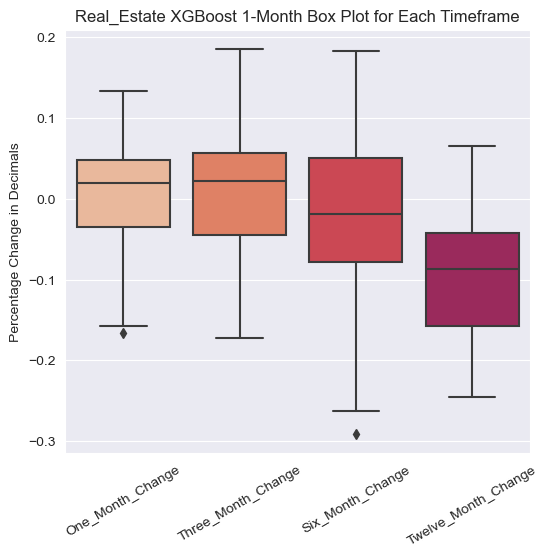

In [308]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Real_Estate[4], "XLRE", cat=1, box=True)[["One_Month_Change"]]

One_Month_Change
count        349.000000
mean          -0.007552
std            0.069443
min           -0.209458
25%           -0.053102
50%            0.005807
75%            0.043157
max            0.133581

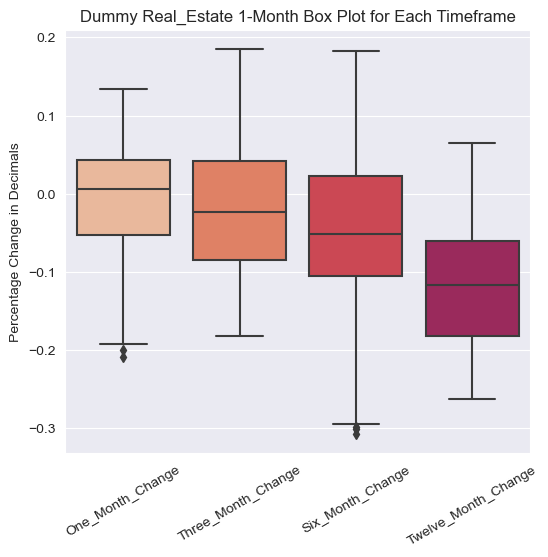

In [307]:
describe_predictions(Real_Estate[0], "XLRE", cat=1, box=True)[["One_Month_Change"]]

### Comparison of Dummy Confusion Matrix to the Best Model

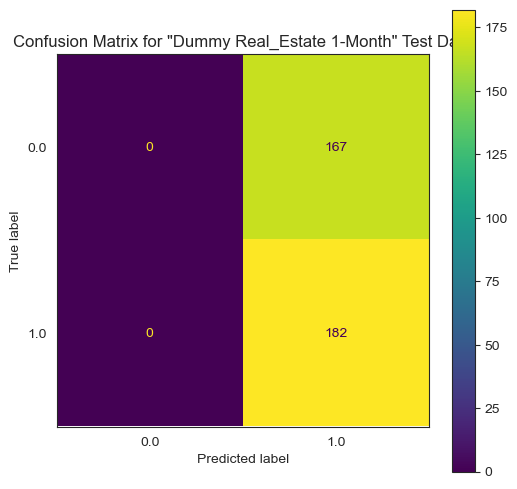

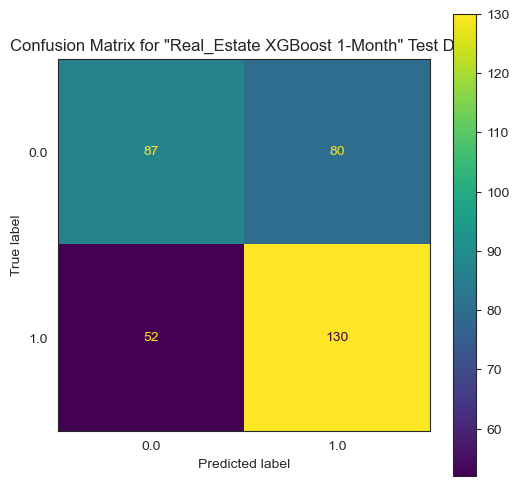

In [309]:
# Shows the best model's predictions and the dummy for that particular time horizon
Real_Estate[0].confusion_matrix(), Real_Estate[4].confusion_matrix();

### Feature Importances

In [310]:
# Feature Importances for each time-horizon's best model
print_feature_importances(36, 40, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
('Month_5', 0.1776)
('cycle_year_4', 0.1342)
('cycle_year_1', 0.0678)
('Open', 0.056)
('GDP_Filled', 0.0506)
****************************************
Top 5 Feature Importance(s):
('Interest_Rates', 0.0539)
('GDP_Filled', 0.0457)
('ATR', 0.0411)
('20_day_SMA', 0.0397)
('High', 0.0379)
****************************************
Top 5 Feature Importance(s):
('Low', 0.2392)
('Interest_Rates', 0.1387)
('ATR', 0.0854)
('GDP_Filled', 0.0794)
('High', 0.0729)
****************************************
Top 5 Feature Importance(s):
('Interest_Rates', 0.0952)
('cycle_year_3', 0.078)
('Low', 0.057)
('ATR', 0.0562)
('20_day_SMA', 0.0543)


<hr style="border: 4px solid black">

# Communication Service XLC

The XLC has only existed since 2018, so once again we suffer from a lack of data, and perhaps our analysis of these results should be tempered by that fact. 

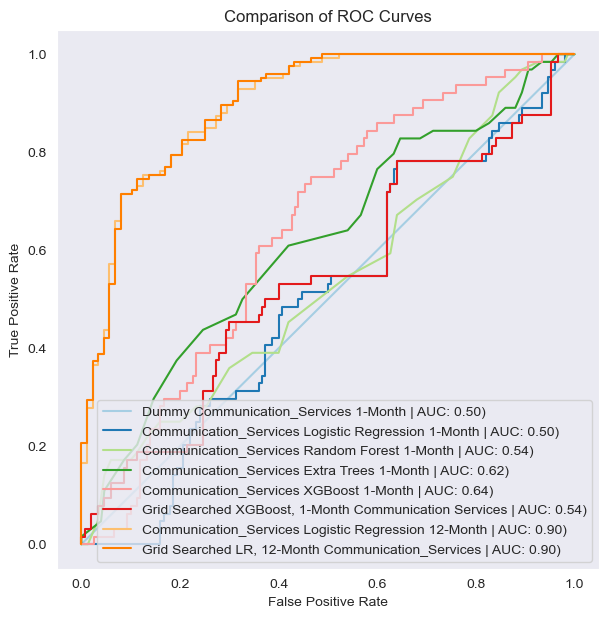

In [320]:
# Comparing the ROC curves of different models to demonstrate the range of performance

compare_curves([Comms[0], Comms[1], Comms[2],Comms[3],Comms[4],Comms[5], \
                Comms[20], Comms[24]])

# 24 was the best model of this sector

### Best Models for the Sector - MORE ZEROS!!!

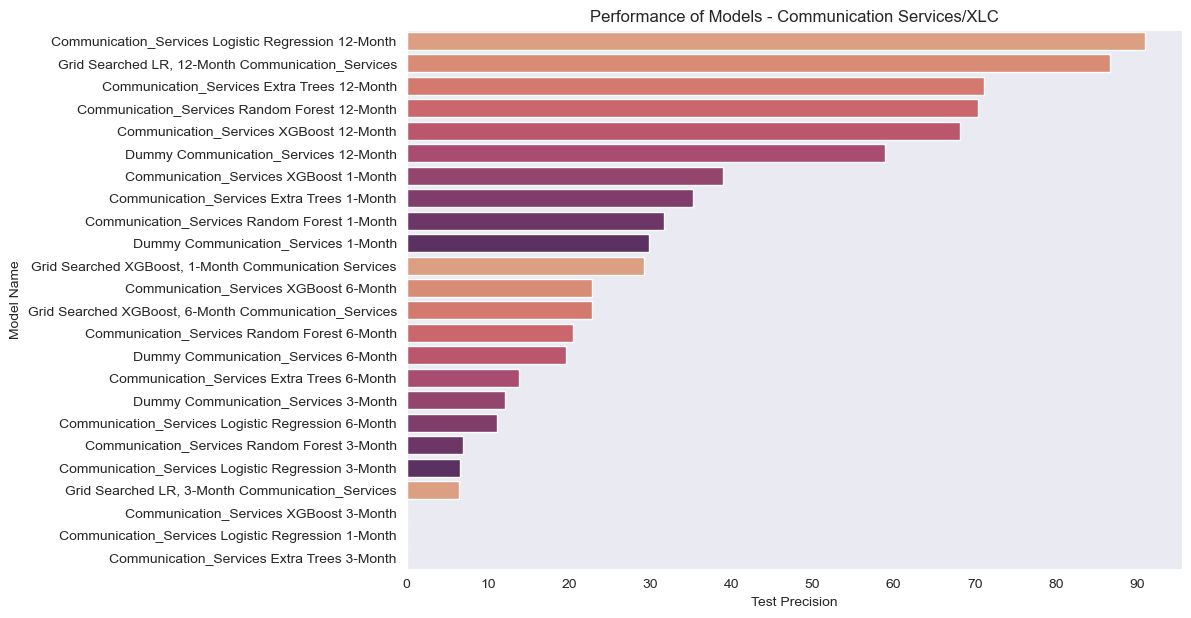

In [312]:
# Plotting the Test precision of every model for this ETF

plot_test_precision(Comms_df, "Communication Services/XLC", num_include=30)

In [313]:
# These were the models with the highest precision score for this ETF

Comms_df.sort_values(by='test_prec', ascending=False)[:5]

name  train_accuracy  \
20  Communication_Services Logistic Regression 12-...        0.807042   
24  Grid Searched LR, 12-Month Communication_Services        0.809859   
22        Communication_Services Extra Trees 12-Month        0.830986   
21      Communication_Services Random Forest 12-Month        0.791549   
23            Communication_Services XGBoost 12-Month        0.833803   

    train_prec  train_recall  train_f1  test_accuracy  test_prec  test_recall  \
20    0.639842      0.796296  0.693229       0.789720   0.909091     0.714286   
24    0.640515      0.800000  0.695063       0.794393   0.866071     0.769841   
22    0.637324      0.788889  0.688782       0.761682   0.711864     1.000000   
21    0.634524      0.743610  0.665169       0.752336   0.703911     1.000000   
23    0.638795      0.790741  0.690421       0.724299   0.681081     1.000000   

     test_f1  test_logloss       AUC  
20  0.800000      0.480459  0.898719  
24  0.815126      0.434271  0.899982  
22  0.831683      0.467283  0.975424  
21  0.826230      0.517828  0.882846  
23  0.810289      1.489212  0.932630

### How did our model perform when predicting "BUY"?
The best model was a 12-month `LogisticRegression` model. As you can see below, looking only at the "Twelve_Month_Change" column, the `median return on predicted "buys" for 12-Months was 19.5%. The worst outcome on a predicted "buy" was a loss of 24.8%.` The mean and median profile of our model is much better than that of the dummy. 

Twelve_Month_Change
count            99.000000
mean              0.177415
std               0.153827
min              -0.248043
25%               0.069706
50%               0.194681
75%               0.290509
max               0.452749

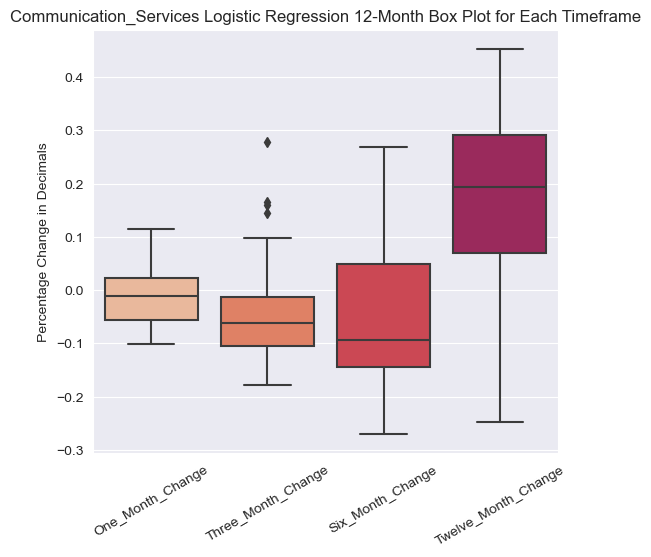

In [317]:
# Prints the .describe() for when y_pred == 1 ('cat' argument can change the prediction to 0)

describe_predictions(Comms[20], "XLC", cat=1, box=True)[["Twelve_Month_Change"]]

Twelve_Month_Change
count           214.000000
mean              0.043072
std               0.224542
min              -0.402171
25%              -0.172215
50%               0.071073
75%               0.224473
max               0.452749

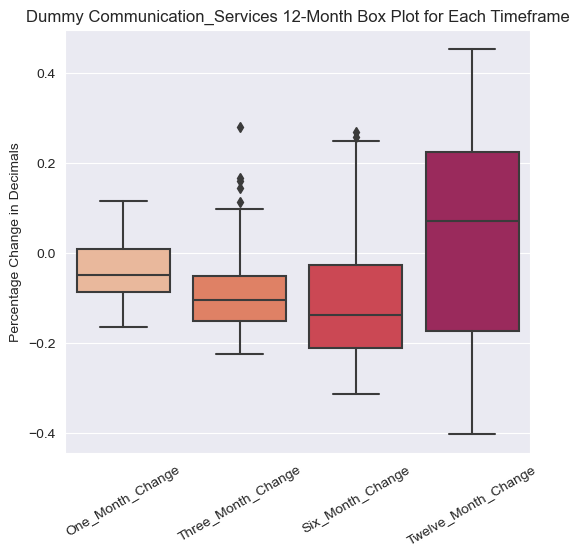

In [319]:
# Dummy Comparison
describe_predictions(Comms[19], "XLC", cat=1, box=True)[["Twelve_Month_Change"]]

### Comparison of Dummy Confusion Matrix to the Best Model

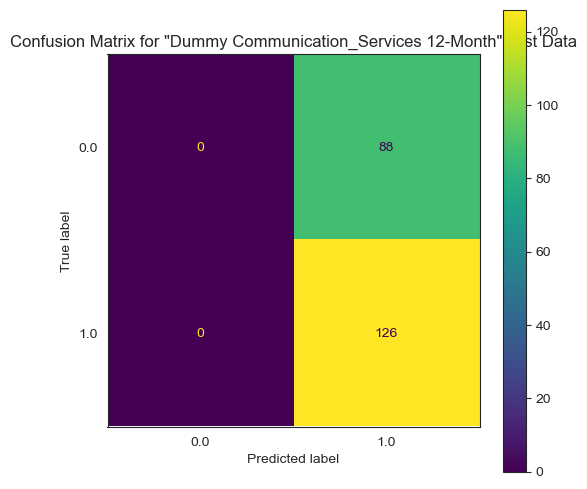

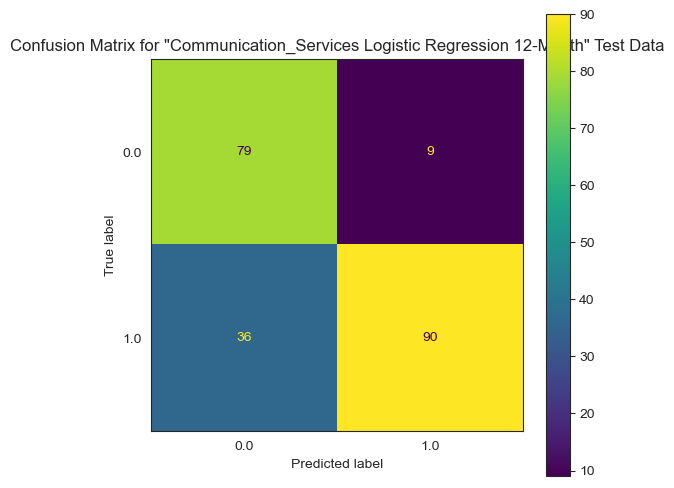

In [321]:
# Shows the best model's predictions and the dummy for that particular time horizon
Comms[19].confusion_matrix(), Comms[20].confusion_matrix();

### Feature Importances

In [322]:
# Feature Importances for each time-horizon's best model
print_feature_importances(40, 44, 1, feats=5)

****************************************
Top 5 Feature Importance(s):
('cycle_year_2', 0.1547)
('Quarter_1', 0.1333)
('Month_11', 0.0744)
('20_day_SMA', 0.0665)
('Month_7', 0.0618)
****************************************
Top 5 Feature Importance(s):
('ATR', 3.9443)
('Interest_Rates', -3.3807)
('MACD', 2.4193)
('cycle_year_2', -2.1175)
('cycle_year_3', 1.9687)
****************************************
Top 5 Feature Importance(s):
('upper_bollinger_band', 0.2044)
('Volume', 0.179)
('Month_10', 0.1645)
('Quarter_2', 0.1025)
('Month_9', 0.1008)
****************************************
Top 5 Feature Importance(s):
('Month_3', -3.2854)
('Month_4', -2.6601)
('Interest_Rates', -2.6038)
('Month_1', 2.5342)
('cycle_year_4', 1.9217)


<hr style="border: 6px solid red">

# Conclusions

The major trends in the analysis are that on longer time horizons, macro-economic factors have a greater influence on predictions, whereas technical indicators have a greater impact on short-term predictions. In the short-term, the adage "the trend is your friend" seems to pay off regularly. For the long-term, "Don't fight the fed" is another adage that seems to hold true as shown by feature importances. Predictions become more accurate in general as time horizons get larger, however that did not mean that the annualized mean gain also got larger. The best models and their profiles are described below.

### Best models for each time horizon (repeated at the top of the notebook)

In [326]:
# One Month
show_time_horizon(models_df, "One")[:5]

name  train_accuracy  train_prec  \
152                 Utilities Extra Trees 1-Month        0.517826    0.651071   
199                Consumer Random Forest 1-Month        0.453350    0.661459   
175                  Health Random Forest 1-Month        0.520354    0.705112   
153                     Utilities XGBoost 1-Month        0.515550    0.654395   
82   GridSearched Best-Model, 1-Month Industrials        0.492035    0.713167   

     train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
152      0.618672  0.581556       0.375421   1.000000     0.006693  0.013298   
199      0.323308  0.396286       0.388889   0.909091     0.013605  0.026810   
175      0.443755  0.494029       0.399832   0.851852     0.031421  0.060606   
153      0.581357  0.586978       0.408249   0.833333     0.073628  0.135301   
82       0.411842  0.440730       0.523569   0.763780     0.277143  0.406709   

     test_logloss       AUC  
152      1.104187  0.557781  
199      1.034222  0.560923  
175      1.022858  0.561392  
153      2.974106  0.592095  
82       0.835841  0.654516

In [327]:
# Three Month
show_time_horizon(models_df, "Three")[:5]

name  train_accuracy  train_prec  \
205     Consumer Random Forest 3-Month        0.564602    0.792703   
109   Technology Random Forest 3-Month        0.497598    0.840695   
61      Financials Extra Trees 3-Month        0.459671    0.615987   
85   Industrials Random Forest 3-Month        0.488748    0.793511   
157    Utilities Random Forest 3-Month        0.519090    0.671392   

     train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
205      0.534682  0.569540       0.349327   1.000000     0.022756  0.044499   
109      0.470452  0.474015       0.335859   1.000000     0.041312  0.079347   
61       0.398116  0.445721       0.468855   0.970930     0.210593  0.346114   
85       0.437685  0.464331       0.500000   0.966480     0.227332  0.368085   
157      0.609332  0.555249       0.325758   0.911504     0.115213  0.204568   

     test_logloss       AUC  
205      1.307216  0.587134  
109      0.929554  0.626951  
61       0.828621  0.733858  
85       0.914622  0.741533  
157      1.492251  0.533627

In [46]:
# Six Month
show_time_horizon(models_df, "Six")[:5]

name  train_accuracy  train_prec  \
140                 Staples Extra Trees 6-Month        0.586852    0.824416   
66             Financials Random Forest 6-Month        0.408344    0.666239   
163             Utilities Random Forest 6-Month        0.460936    0.695637   
166  GridSearched Best-Model, 6-Month Utilities        0.520607    0.872435   
68                   Financials XGBoost 6-Month        0.447535    0.712225   

     train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
140      0.655801  0.662899       0.241582   1.000000     0.034298  0.066321   
66       0.298965  0.365130       0.507576   1.000000     0.202997  0.337486   
163      0.421033  0.423809       0.318182   1.000000     0.129032  0.228571   
166      0.506966  0.542419       0.332492   1.000000     0.147312  0.256795   
68       0.390537  0.455941       0.478114   0.991379     0.156676  0.270588   

     test_logloss       AUC  
140      1.137789  0.806921  
66       0.944096  0.739135  
163      1.109118  0.543482  
166      1.055865  0.539285  
68       3.035870  0.630505

In [45]:
# Twelve Month
show_time_horizon(models_df, "Twelve")[:5]

name  train_accuracy  train_prec  \
145               Staples Random Forest 12-Month        0.707206    0.945162   
26   GridSearched Best-Model, 12-Month Materials        0.465487    0.923752   
98              Industrials Extra Trees 12-Month        0.467004    0.899688   
146                 Staples Extra Trees 12-Month        0.702655    0.946276   
97            Industrials Random Forest 12-Month        0.359798    0.721174   

     train_recall  train_f1  test_accuracy  test_prec  test_recall   test_f1  \
145      0.712891  0.756944       0.238215        1.0     0.168962  0.289081   
26       0.432962  0.429556       0.417508        1.0     0.095425  0.174224   
98       0.499557  0.557977       0.397306        1.0     0.138387  0.243129   
146      0.704716  0.747391       0.261785        1.0     0.194674  0.325903   
97       0.358613  0.398701       0.387205        1.0     0.123947  0.220557   

     test_logloss       AUC  
145      1.976692  0.648788  
26       1.186516  0.644143  
98       1.157699  0.591636  
146      1.196163  0.764277  
97       2.732087  0.648921

### Recommendation
This study proved challenging to calibrate. Once precision was established as the target metric, more decisions had to be made about the viability of those models. Many models achieved 100% precision, but they predicted positives so rarely that the likelihood of actually making more gains off those sporadic recommendations versus being a passive buyer was very low. I had to be selective not only about the precision, but the volume of predictions. Overall, the selected models were all very effective, and resulted in positive expected gains. Boosted models like XGBoost and ExtraTreesClassifier were most frequently best in class, however Logistic Regression did factor in as the best predictor in a few categories as well. 

I also think that it is worth mentioning how every model's targeted timeframe has a low rate of negative outlier returns. For the longer dated predictions, the plots `also` show how these predictions do not result in a straight line from lower left to upper right. You can see in this example below, a 12-month "buy" prediction may endure a bumpy ride. The return at 1, 3, and 6 months along into a 12-month buy prediction had very wide outcomes. Still, by target prediction date, the model produced consistently positive results with very small losses on average.

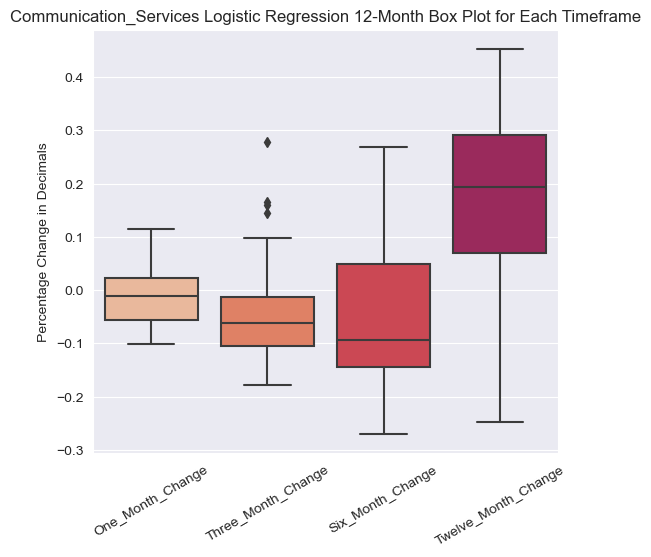

This emphasizes the required patience for the model's predictions, and the importance of not cutting bait midway through a time period when the prediction might be experiencing a loss.

### Next Steps:
The next steps would be to, of course, continue to update the data with more observations. The years following covid have been described as atypical by many market commentators. Having data on 2023 would have been interesting to study given that Federal interest rates are the highest they have been in a long time, and yet the S&P 500 is still up 14.16% at this time I am writing this. It would also be beneficial to add more features, such as the price of various commodities, such as oil, gold, wheat etc. There is still the potential to add many additional technical indicators as well, and all of these factors could conceivably improve the performance of the models, even though they have already achieved remarkable accuracy. 

In the next notebook, I will begin to investigate Uni-Variate Time Series Modeling